# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

# import libraries here; add more as necessary
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from IPython import display

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor


from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# magic word for producing visualizations in notebook
%matplotlib inline


## Import and format the data

This notebook explores the subset of the users where valid responses for age, gender, and income are recorded.  The performance of the Regression learners will be compared against a previously completed version where 'No Response' is considered a gender, and invalid age and income values are imputed.

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile_raw = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
profile = profile_raw[(profile_raw['age'] != 118) & (profile_raw['income'] == profile_raw['income'])].copy()

### Format the Transctipt
Have: a series of JSON values

Want: a properly formatted dataframe

In [2]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [3]:
## 'values' column looks like it has inconsistent keys: explore the data keys here

all_index_keys = transcript['value'].unique
all_index_keys

<bound method Series.unique of 0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16       

In [4]:
def get_offer_id(entry):
    '''
    in: an event JSON object from the transcript
    out: the id of the offer, or -1 if not there
    '''
    if 'offer_id' in entry:
        return entry['offer_id']
    elif 'offer id' in entry:
        return entry['offer id']
    else:
        return -1
    
def get_amount(entry):
    '''
    in: an event JSON object from the transcript
    out: the amount of the transaction, or -1 if not therele
    '''
    if 'amount' in entry:
        return entry['amount']
    else:
        return -1
    
def get_reward(entry):
    '''
    in: an event JSON object from the transcript
    out: the reward of the transaction, or -1 if not therele
    '''
    if 'reward' in entry:
        return entry['reward']
    else:
        return -1
    

In [5]:
transcript['offer_id'] = transcript['value'].apply(get_offer_id)
transcript['amount'] = transcript['value'].apply(get_amount)
transcript['reward'] = transcript['value'].apply(get_reward)

#### The finalized transcript dataframe:

In [6]:
transcript[['value','offer_id', 'reward', 'amount']]

,value,offer_id,reward,amount
0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1,-1.00
1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1,-1.00
2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,-1,-1.00
3,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,-1,-1.00
4,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,-1,-1.00
5,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,-1,-1.00
6,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,-1,-1.00
7,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,-1,-1.00
8,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1,-1.00
9,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1,-1.00


## Explore the Data

In [7]:
# Examine the offer ids
portfolio.head(20)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [8]:
transcript.head(20)
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [9]:
profile.head(20)

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0


Check the encoding of gender

In [162]:
profile.gender.unique()

array(['F', 'M', 'O'], dtype=object)

Check the encoding of the ages

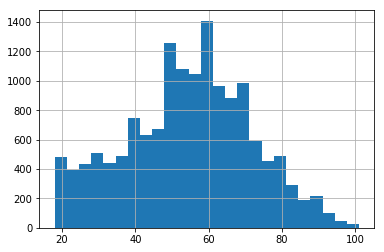

In [11]:
profile.age.hist(bins = 25)

Check the encoding of the income

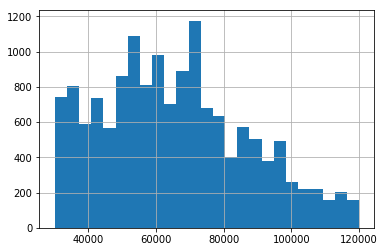

In [12]:
profile.income.hist(bins = 25)

In [13]:
profile.shape

(14825, 5)

In [14]:
## Discussion of variable types
##TODO

In [14]:
mean_age = int(profile[profile['age'] != 118]['age'].sum() / profile[profile['age'] != 118].shape[0])
mean_age

54

In [15]:
mean_income = profile[profile['income'].isnull() == False]['income'].sum() / profile[profile['income'].isnull() == False].shape[0]
mean_income

65404.9915682968

In [10]:
## Fixed by removing non-responses

#def impute_age(age):
#    if age == 118:
#        return mean_age
#    else:
#        return age
    
#def impute_income(income):
#    if income != income: #since np.NaN != np.NaN
#        return mean_income
#    else:
#        return income
    
#profile['age'] = profile['age'].apply(lambda x: impute_age(x))
#profile['income'] = profile['income'].apply(lambda x: impute_income(x))

In [16]:
import datetime
from dateutil.parser import parse

def parse_date(date_string):
    """
    parses a date from a string, and catches string formatting exceptions (returns empty string)
    """
    try:
        event_date = datetime.datetime.strptime(str(date_string).strip(), "%Y%m%d").date()
    except:
        event_date = ""
    return event_date

In [17]:
profile['date_parsed'] = profile['became_member_on'].apply(parse_date)
today = datetime.datetime.strptime('20190301', "%Y%m%d").date()
profile['member_for'] = today - profile['date_parsed']
profile['member_for'] = profile['member_for'].apply(lambda x: int(x.days/7))

In [18]:
def encode_gender(gend):
    '''
    Correctly encodes gender
    In: a value for gender
    Out: the same value, except None type is replaced by the string 'No_response'
    '''
    if gend is None:
        return 'No_response'
    else:
        return gend

profile['gender'] = profile['gender'].apply(encode_gender)

profile.head(20)

,age,became_member_on,gender,id,income,date_parsed,member_for
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,84
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,94
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,44
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,55
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,67
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017-09-11,76
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014-02-13,263
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016-02-11,159
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014-11-13,224
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,2017-12-31,60


In [19]:
transcript.head(5)

,event,person,time,value,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1.0,-1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,-1.0,-1
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,-1.0,-1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,-1.0,-1
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,-1.0,-1


In [20]:
## some people recevice many offers, and produce many transactions.
## This is helpful as it will give a good prior predictor for the time sereis

transcript[transcript['person'] == '94de646f7b6041228ca7dec82adb97d2']

,event,person,time,value,offer_id,amount,reward
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,-1.00,-1
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,-1.00,-1
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,{'amount': 7.41},-1,7.41,-1
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,f19421c1d4aa40978ebb69ca19b0e20d,-1.00,5
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,{'amount': 1.47},-1,1.47,-1
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1.00,-1
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,-1.00,-1
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,{'amount': 2.62},-1,2.62,-1
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,{'amount': 0.59},-1,0.59,-1
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,{'amount': 2.2800000000000002},-1,2.28,-1


#### Times that offers take place

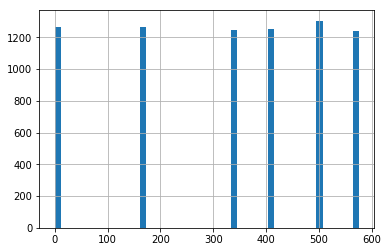

In [21]:
transcript[(transcript['offer_id'] == 'f19421c1d4aa40978ebb69ca19b0e20d') & (transcript['event'] == 'offer received')]['time'].hist(bins = 50)

Observation: Offers are sent during one of six "slots".  The start of one slot may overlap the previous offer.  This means a user may potentially have more than one offer in effect at a given time.

#### Times that transactions take place

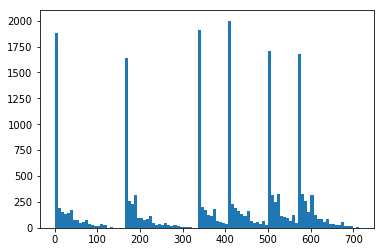

In [176]:
#Test run for all transactions within the duration of ae264e3637204a6fb9bb56bc8210ddfd
#channels	difficulty	duration	id	offer_type	reward

transactions = []

offer_id = portfolio.loc[8, 'id']
offer_duration_days = portfolio.loc[8, 'duration']
offer_duration_hours = 24 * offer_duration_days

#lookup the users who received the offer and the start time
transactions = transcript[transcript['offer_id'] == str(offer_id)]['time']

#transaction_times = [i[0] for i in transactions]
plt.hist(transactions, bins = 100)

plt.show()


Observation: An offer is made during any of the offering periods.

Observation: Offers may last up to 20 days x 24 hours = 480 hours, so offer periods overlap.
This means that a transaction may be a result of another, older offer, or the person might have been going to make the transaction anyways.

Observation: The transaction times are "quantized" into four-hour intervals.


#### Transaction counts, Offer 8

Offer takes place at t=20.  Histogram plots transaction count for sers who are sent offer 8.  Visually shows impact of offer over its duration of.

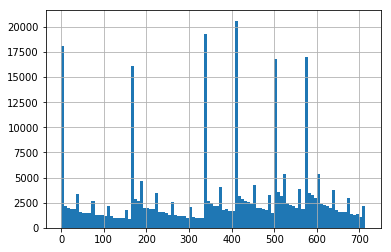

In [178]:
transcript['time'].hist(bins = 100)

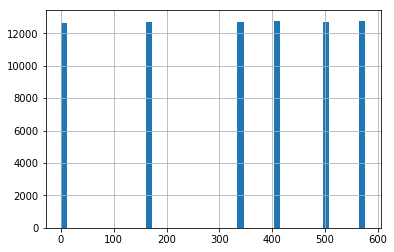

In [25]:
transcript[transcript['event'] == 'offer received']['time'].hist(bins = 50)

In [26]:
offer_durations = {}
for index, row in portfolio.iterrows():
    offer_durations[row['id']] = row['duration'] * 24



In [27]:
## Who are the customers who responded to BOGO
## Who are the customers who responded to informational
## Who are the custoemrs who responded to discount

discount_ids = list(portfolio[portfolio['offer_type'] == 'discount']['id'])
bogo_ids = list(portfolio[portfolio['offer_type'] == 'bogo']['id'])
informational_ids = list(portfolio[portfolio['offer_type'] == 'informational']['id'])

In [19]:
bogo_ids

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'f19421c1d4aa40978ebb69ca19b0e20d']

In [28]:
#Build uesr-discount target record

offer_names = {}

offer_names['ae264e3637204a6fb9bb56bc8210ddfd'] = 'bogo_1'
offer_names['4d5c57ea9a6940dd891ad53e9dbe8da0'] = 'bogo_2'
offer_names['3f207df678b143eea3cee63160fa8bed'] = 'info_1'
offer_names['9b98b8c7a33c4b65b9aebfe6a799e6d9'] = 'bogo_3'
offer_names['0b1e1539f2cc45b7b9fa7c272da2e1d7'] = 'discount_1'
offer_names['2298d6c36e964ae4a3e7e9706d1fb8c2'] = 'discount_2'
offer_names['fafdcd668e3743c1bb461111dcafc2a4'] = 'discount_3'
offer_names['5a8bc65990b245e5a138643cd4eb9837'] = 'info_2'
offer_names['f19421c1d4aa40978ebb69ca19b0e20d'] = 'bogo_4'
offer_names['2906b810c7d4411798c6938adc9daaa5'] = 'discount_4'

user_offer_cols = ['person', 'discount_1', 'discount_2', 'discount_3', 'discount_4', 'bogo_1', 'bogo_2', 'bogo_3',
'bogo_4', 'info_1', 'info_2']




In [29]:
## Initialize the user-offer matrix with zeros

df_user_offer = pd.DataFrame(0, index=profile['id'], columns=user_offer_cols)

In [30]:
## Set the user ids from the profiles

df_user_offer['person'] = profile['id']

for i in df_user_offer.index:
    df_user_offer.loc[i, 'person'] = i

df_user_offer

,person,discount_1,discount_2,discount_3,discount_4,bogo_1,bogo_2,bogo_3,bogo_4,info_1,info_2
id,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,0,0,0,0
e2127556f4f64592b11af22de27a7932,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,0,0,0,0,0
389bc3fa690240e798340f5a15918d5c,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,0,0,0,0,0
2eeac8d8feae4a8cad5a6af0499a211d,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,0,0,0,0,0,0
aa4862eba776480b8bb9c68455b8c2e1,aa4862eba776480b8bb9c68455b8c2e1,0,0,0,0,0,0,0,0,0,0
e12aeaf2d47d42479ea1c4ac3d8286c6,e12aeaf2d47d42479ea1c4ac3d8286c6,0,0,0,0,0,0,0,0,0,0
31dda685af34476cad5bc968bdb01c53,31dda685af34476cad5bc968bdb01c53,0,0,0,0,0,0,0,0,0,0
62cf5e10845442329191fc246e7bcea3,62cf5e10845442329191fc246e7bcea3,0,0,0,0,0,0,0,0,0,0


In [31]:
## Populate the user-offer matrix

def populate_user_offer(row):
    '''
    Fills in the values of the user-offer matrix
    If the row contains an offer, increment the value of the intersection of user_id, offer in the matrix
    '''
    if row['offer_id'] != -1:
        user = str(row['person'])
        offer = str(offer_names[row['offer_id']])        
        df_user_offer.loc[df_user_offer['person'] == user, offer] += 1
        

In [32]:
transcript.apply(populate_user_offer, axis = 1)

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9         None
10        None
11        None
12        None
13        None
14        None
15        None
16        None
17        None
18        None
19        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29        None
          ... 
306504    None
306505    None
306506    None
306507    None
306508    None
306509    None
306510    None
306511    None
306512    None
306513    None
306514    None
306515    None
306516    None
306517    None
306518    None
306519    None
306520    None
306521    None
306522    None
306523    None
306524    None
306525    None
306526    None
306527    None
306528    None
306529    None
306530    None
306531    None
306532    None
306533    None
Length: 306534, dtype: object

In [33]:
df_user_offer

,person,discount_1,discount_2,discount_3,discount_4,bogo_1,bogo_2,bogo_3,bogo_4,info_1,info_2
id,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,2,0,1,0
78afa995795e4d85b5d9ceeca43f5fef,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,3,0,3,3,0,2
e2127556f4f64592b11af22de27a7932,e2127556f4f64592b11af22de27a7932,0,0,3,2,0,0,3,0,1,0
389bc3fa690240e798340f5a15918d5c,389bc3fa690240e798340f5a15918d5c,0,0,3,3,0,0,5,6,0,0
2eeac8d8feae4a8cad5a6af0499a211d,2eeac8d8feae4a8cad5a6af0499a211d,0,2,3,0,0,0,0,0,1,0
aa4862eba776480b8bb9c68455b8c2e1,aa4862eba776480b8bb9c68455b8c2e1,2,0,0,0,3,3,0,3,0,2
e12aeaf2d47d42479ea1c4ac3d8286c6,e12aeaf2d47d42479ea1c4ac3d8286c6,4,0,0,2,2,0,0,0,0,0
31dda685af34476cad5bc968bdb01c53,31dda685af34476cad5bc968bdb01c53,2,8,5,0,0,0,0,0,0,0
62cf5e10845442329191fc246e7bcea3,62cf5e10845442329191fc246e7bcea3,1,0,0,0,3,0,0,0,0,2


In [34]:
df = profile.join(df_user_offer.set_index('person'), on='id')
df

,age,became_member_on,gender,id,income,date_parsed,member_for,discount_1,discount_2,discount_3,discount_4,bogo_1,bogo_2,bogo_3,bogo_4,info_1,info_2
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,84,0,0,0,0,0,0,2,0,1,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,94,0,0,0,0,3,0,3,3,0,2
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,44,0,0,3,2,0,0,3,0,1,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,55,0,0,3,3,0,0,5,6,0,0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,67,0,2,3,0,0,0,0,0,1,0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017-09-11,76,2,0,0,0,3,3,0,3,0,2
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014-02-13,263,4,0,0,2,2,0,0,0,0,0
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016-02-11,159,2,8,5,0,0,0,0,0,0,0
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014-11-13,224,1,0,0,0,3,0,0,0,0,2
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,2017-12-31,60,1,3,0,0,0,0,3,0,1,0


### Getting transaction records

In [35]:
def get_transactions_by_offer(person):
    '''
    Returns the transactions associated with a user's id
    in: a person's id
    out: 
        offer_transactions:
            a dictionary of <offer_id: [(transaction_time, transaction_value)]
            transactions made within the offer period
        no_offer_transactions:
            a list of [(transaction_time, transaction_value)]
            transactions made outside the validity period of any offer
    '''
    
    #track <elapsed time, amount> tuples for each offer 
    offer_transactions = {}
    #track the time each offer started for each user
    offer_starts = {}
    #for transactions outside any offer period
    no_offer_transactions = []    
    
    for offer in portfolio['id']:
        offer_transactions[offer] = []
        offer_starts[offer] = -9999999
    
    
    for index, row in transcript[transcript['person'] == person].iterrows():
        if row['event'] == 'offer received':
            offer_starts[row['offer_id']] = int(row['time'])
            #print(row['offer_id'] + '  ' + str(row['time']))
        elif row['event'] == 'transaction':
            part_of_offer = False
            for offer in offer_starts:
                if row['time'] <= offer_starts[offer] + offer_durations[offer]:
                    part_of_offer = True
                    offer_transactions[offer].append((row['time'] - offer_starts[offer], row['amount']))
            if part_of_offer == False:
                no_offer_transactions.append((row['time'], row['amount']))

    return offer_transactions, no_offer_transactions

def populate_transactions(row):
    '''
    Populates the transactions matrix
    In: a row of data
    Calls the get_transactions_by_offer function and fils in the row's 'bogo_1', etc. columns
    '''
    offer_transactions, no_offer_transactions = get_transactions_by_offer(row['id'])
    
    #print(offer_transactions)
   
    row['bogo_1_transactions'] = offer_transactions['ae264e3637204a6fb9bb56bc8210ddfd']
    row['bogo_2_transactions'] = offer_transactions['4d5c57ea9a6940dd891ad53e9dbe8da0']
    row['bogo_3_transactions'] = offer_transactions['9b98b8c7a33c4b65b9aebfe6a799e6d9']
    row['bogo_4_transactions'] = offer_transactions['f19421c1d4aa40978ebb69ca19b0e20d']
    row['discount_1_transactions'] = offer_transactions['0b1e1539f2cc45b7b9fa7c272da2e1d7']
    row['discount_2_transactions'] = offer_transactions['2298d6c36e964ae4a3e7e9706d1fb8c2']
    row['discount_3_transactions'] = offer_transactions['fafdcd668e3743c1bb461111dcafc2a4']
    row['discount_4_transactions'] = offer_transactions['2906b810c7d4411798c6938adc9daaa5']
    row['info_1_transactions'] = offer_transactions['3f207df678b143eea3cee63160fa8bed']
    row['info_2_transactions'] = offer_transactions['5a8bc65990b245e5a138643cd4eb9837']
    
    row['no_offer_transactions'] = no_offer_transactions
    
    #print(str(no_offer_transactions))
    print(str(row['no_offer_transactions']))
    
    

In [36]:
def merge_intervals(intervals):
    '''
    Merges intervals
    in: a list of intervals, expressed as tuples (start, end)
    out: a list with the same intervals, but overlappign intervals are merged
    '''
    sorted_intervals = sorted(intervals, key=lambda x: x[0])
    
    if len(sorted_intervals) == 0:
        return sorted_intervals
    
    merging_stack = []
    merging_stack.append(sorted_intervals[0])
    
    for i in range(1, len(sorted_intervals)):
           
        if merging_stack[len(merging_stack)-1][1] < sorted_intervals[i][0]: #disjoint interval
            merging_stack.append(sorted_intervals[i])
        
        elif merging_stack[len(merging_stack)-1][1] < sorted_intervals[i][1]: # otherwise merge
            merged_interval = ( merging_stack[len(merging_stack)-1][0], sorted_intervals[i][1])
            merging_stack.pop(len(merging_stack)-1)
            merging_stack.append(merged_interval)
            
    return merging_stack


#test_list = [(1,2),(11,12), (3,6), (4,5), (5,7)]

#test_result = merge_intervals(test_list)
#test_result
    
    

## Populate transaction records by user

In [37]:
df['bogo_1_transactions'] = 0#df['bogo_1_transactions'].astype(object)
df['bogo_2_transactions'] = 0#df['bogo_2_transactions'].astype(object)
df['bogo_3_transactions'] = 0#df['bogo_3_transactions'].astype(object)
df['bogo_4_transactions'] = 0#df['bogo_4_transactions'].astype(object)
df['discount_1_transactions'] = 0#df['discount_1_transactions'].astype(object)
df['discount_2_transactions'] = 0#df['discount_2_transactions'].astype(object)
df['discount_3_transactions'] = 0#df['discount_3_transactions'].astype(object)
df['discount_4_transactions'] = 0#df['discount_4_transactions'].astype(object)
df['info_1_transactions'] = 0#df['info_1_transactions'].astype(object)
df['info_2_transactions'] = 0#df['info_2_transactions'].astype(object)
df['no_offer_transactions'] = 0#df['no_offer_transactions'].astype(object)

df['bogo_1_transactions'] = df['bogo_1_transactions'].astype(object)
df['bogo_2_transactions'] = df['bogo_2_transactions'].astype(object)
df['bogo_3_transactions'] = df['bogo_3_transactions'].astype(object)
df['bogo_4_transactions'] = df['bogo_4_transactions'].astype(object)
df['discount_1_transactions'] = df['discount_1_transactions'].astype(object)
df['discount_2_transactions'] = df['discount_2_transactions'].astype(object)
df['discount_3_transactions'] = df['discount_3_transactions'].astype(object)
df['discount_4_transactions'] = df['discount_4_transactions'].astype(object)
df['info_1_transactions'] = df['info_1_transactions'].astype(object)
df['info_2_transactions'] = df['info_2_transactions'].astype(object)
df['no_offer_transactions'] = df['no_offer_transactions'].astype(object)

for index, row in df.iterrows():
    df.at[index, 'bogo_1_transactions'] = []
    df.at[index, 'bogo_2_transactions'] = []
    df.at[index, 'bogo_3_transactions'] = []
    df.at[index, 'bogo_4_transactions'] = []
    df.at[index, 'discount_1_transactions'] = []
    df.at[index, 'discount_2_transactions'] = []
    df.at[index, 'discount_3_transactions'] = []
    df.at[index, 'discount_4_transactions'] = []
    df.at[index, 'info_1_transactions'] = []
    df.at[index, 'info_2_transactions'] = []
    df.at[index, 'no_offer_transactions'] = []
    #df.at[index, 'no_offer_interval'] = 0

In [46]:
for index, row in df.iterrows():
    offer_transactions, no_offer_transactions = get_transactions_by_offer(row['id'])
    
    #print(offer_transactions)
   
    df.at[index, 'bogo_1_transactions'] = offer_transactions['ae264e3637204a6fb9bb56bc8210ddfd']
    df.at[index, 'bogo_2_transactions'] = offer_transactions['4d5c57ea9a6940dd891ad53e9dbe8da0']
    df.at[index, 'bogo_3_transactions'] = offer_transactions['9b98b8c7a33c4b65b9aebfe6a799e6d9']
    df.at[index, 'bogo_4_transactions'] = offer_transactions['f19421c1d4aa40978ebb69ca19b0e20d']
    df.at[index, 'discount_1_transactions'] = offer_transactions['0b1e1539f2cc45b7b9fa7c272da2e1d7']
    df.at[index, 'discount_2_transactions'] = offer_transactions['2298d6c36e964ae4a3e7e9706d1fb8c2']
    df.at[index, 'discount_3_transactions'] = offer_transactions['fafdcd668e3743c1bb461111dcafc2a4']
    df.at[index, 'discount_4_transactions'] = offer_transactions['2906b810c7d4411798c6938adc9daaa5']
    df.at[index, 'info_1_transactions'] = offer_transactions['3f207df678b143eea3cee63160fa8bed']
    df.at[index, 'info_2_transactions'] = offer_transactions['5a8bc65990b245e5a138643cd4eb9837']
    
    df.at[index, 'no_offer_transactions'] = no_offer_transactions
    

In [47]:
df.head(20)

,age,became_member_on,gender,id,income,date_parsed,member_for,discount_1,discount_2,discount_3,...,discount_1_rate,discount_1_avg_val,discount_2_rate,discount_2_avg_val,discount_3_rate,discount_3_avg_val,discount_4_rate,discount_4_avg_val,no_offer_rate,no_offer_avg_val
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,84,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,94,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,44,0,0,3,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,55,0,0,3,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,67,0,2,3,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017-09-11,76,2,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014-02-13,263,4,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016-02-11,159,2,8,5,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014-11-13,224,1,0,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,2017-12-31,60,1,3,0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0


In [48]:
def get_no_offer_interval(row):
    '''
    Determines the amount of time in hours during with a user had no valid offers
    '''
    intervals = []
    duration = 714
    
    if row['discount_1'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (10*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    if row['discount_2'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == '2298d6c36e964ae4a3e7e9706d1fb8c2') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (7*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    if row['discount_3'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (10*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    if row['discount_4'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == '2906b810c7d4411798c6938adc9daaa5') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (7*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    if row['bogo_1'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (7*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
    
    if row['bogo_2'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (5*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
    
    if row['bogo_3'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (7*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    if row['bogo_4'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == 'f19421c1d4aa40978ebb69ca19b0e20d') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (5*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    if row['info_1'] >= 1:
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == '3f207df678b143eea3cee63160fa8bed') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (4*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    if row['info_2'] >= 1:    
        for k in transcript[(transcript['person'] == row['id']) & (transcript['offer_id'] == '5a8bc65990b245e5a138643cd4eb9837') & (transcript['event'] == 'offer received')]['time']:
            start = int(k)
            end = min(start + (3*24), duration) #lesser of duration and the end of the data
            intervals.append((start, end))
        
    intervals_with_offers = merge_intervals(intervals)
    
    total_offer_time = 0
    for interval in intervals_with_offers:
        total_offer_time += (interval[1] - interval[0])
        
    time_with_no_offer = duration - total_offer_time
    
    #print("Offer interval: " + str(intervals_with_offers) + "   Time with no offer: " + str(time_with_no_offer))
    
    return time_with_no_offer
        

In [49]:
df['no_offer_interval'] = df.apply(get_no_offer_interval, axis = 1)

In [50]:
#The above code took ~45 minutes to run, I'm going to serialize it at this point
import pickle
df.to_pickle("./profile-transactions_complete_alt.pkl")

In [51]:
## Determine transaction rates and average transaction size

df['bogo_1_rate'] = 0
df['bogo_1_avg_val'] = 0
df['bogo_2_rate'] = 0
df['bogo_2_avg_val'] = 0
df['bogo_3_rate'] = 0
df['bogo_3_avg_val'] = 0
df['bogo_4_rate'] = 0
df['bogo_4_avg_val'] = 0
df['info_1_rate'] = 0
df['info_1_avg_val'] = 0
df['info_2_rate'] = 0
df['info_2_avg_val'] = 0
df['discount_1_rate'] = 0
df['discount_1_avg_val'] = 0
df['discount_2_rate'] = 0
df['discount_2_avg_val'] = 0
df['discount_3_rate'] = 0
df['discount_3_avg_val'] = 0
df['discount_4_rate'] = 0
df['discount_4_avg_val'] = 0
df['no_offer_rate'] = 0
df['no_offer_avg_val'] = 0

bogo_1_duration = 7*24
bogo_2_duration = 5*24
bogo_3_duration = 7*24
bogo_4_duration = 5*24
info_1_duration = 4*24
info_2_duration = 3*24
discount_1_duration = 10*24
discount_2_duration = 7*24
discount_3_duration = 10*24
discount_4_duration = 7*24


def fill_out_transaction_rates(row):
    '''
    Calculates transaction rates and average transaction value for each offer type, also baseline values, for each user
    Fills in np.NaN if the interval is zero.
    '''
    if row['bogo_1'] == 0:
        row['bogo_1_rate'] = np.NaN
        row['bogo_1_avg_val'] = np.NaN
    elif len(row['bogo_1_transactions']) == 0:
        row['bogo_1_rate'] = 0
        row['bogo_1_avg_val'] = 0        
    else:        
        row['bogo_1_rate'] = len(row['bogo_1_transactions']) / (bogo_1_duration * row['bogo_1'])
        row['bogo_1_avg_val'] = sum(i[1] for i in row['bogo_1_transactions']) / len(row['bogo_1_transactions'])
    
    if row['bogo_2'] == 0:
        row['bogo_2_rate'] = np.NaN
        row['bogo_2_avg_val'] = np.NaN
    elif len(row['bogo_2_transactions']) == 0:
        row['bogo_2_rate'] = 0
        row['bogo_2_avg_val'] = 0   
    else:
        row['bogo_2_rate'] = len(row['bogo_2_transactions']) / (bogo_2_duration * row['bogo_2'])
        row['bogo_2_avg_val'] = sum(i[1] for i in row['bogo_2_transactions']) / len(row['bogo_2_transactions'])

    if row['bogo_3'] == 0:
        row['bogo_3_rate'] = np.NaN
        row['bogo_3_avg_val'] = np.NaN
    elif len(row['bogo_3_transactions']) == 0:
        row['bogo_3_rate'] = 0
        row['bogo_3_avg_val'] = 0   
    else:
        row['bogo_3_rate'] = len(row['bogo_3_transactions']) / (bogo_3_duration * row['bogo_3'])
        row['bogo_3_avg_val'] = sum(i[1] for i in row['bogo_3_transactions'])  / len(row['bogo_3_transactions'])

    if row['bogo_4'] == 0:
        row['bogo_4_rate'] = np.NaN
        row['bogo_4_avg_val'] = np.NaN
    elif len(row['bogo_4_transactions']) == 0:
        row['bogo_4_rate'] = 0
        row['bogo_4_avg_val'] = 0   
    else:
        row['bogo_4_rate'] = len(row['bogo_4_transactions']) / (bogo_4_duration * row['bogo_4'])
        row['bogo_4_avg_val'] = sum(i[1] for i in row['bogo_4_transactions']) / len(row['bogo_4_transactions'])
        
    if row['info_1'] == 0:
        row['info_1_rate'] = np.NaN
        row['info_1_avg_val'] = np.NaN
    elif len(row['info_1_transactions']) == 0:
        row['info_1_rate'] = 0
        row['info_1_avg_val'] = 0   
    else:
        row['info_1_rate'] = len(row['info_1_transactions']) / (info_1_duration * row['info_1'])
        row['info_1_avg_val'] = sum(i[1] for i in row['info_1_transactions']) / len(row['info_1_transactions'])

    if row['info_2'] == 0:
        row['info_2_rate'] = np.NaN
        row['info_2_avg_val'] = np.NaN
    elif len(row['info_2_transactions']) == 0:
        row['info_2_rate'] = 0
        row['info_2_avg_val'] = 0   
    else:
        row['info_2_rate'] = len(row['info_2_transactions']) / (info_2_duration * row['info_2'])
        row['info_2_avg_val'] = sum(i[1] for i in row['info_2_transactions']) / len(row['info_2_transactions'])
        
    if row['discount_1'] == 0:
        row['discount_1_rate'] = np.NaN
        row['discount_1_avg_val'] = np.NaN
    elif len(row['discount_1_transactions']) == 0:
        row['discount_1_rate'] = 0
        row['discount_1_avg_val'] = 0   
    else:
        row['discount_1_rate'] = len(row['discount_1_transactions']) / (discount_1_duration * row['discount_1'])
        row['discount_1_avg_val'] = sum(i[1] for i in row['discount_1_transactions']) / len(row['discount_1_transactions'])
    
    if row['discount_2'] == 0:
        row['discount_2_rate'] = np.NaN
        row['discount_2_avg_val'] = np.NaN
    elif len(row['discount_2_transactions']) == 0:
        row['discount_2_rate'] = 0
        row['discount_2_avg_val'] = 0   
    else:
        row['discount_2_rate'] = len(row['discount_2_transactions']) / (discount_2_duration * row['discount_2'])
        row['discount_2_avg_val'] = sum(i[1] for i in row['discount_2_transactions']) / len(row['discount_2_transactions'])
        
    if row['discount_3'] == 0:
        row['discount_3_rate'] = np.NaN
        row['discount_3_avg_val'] = np.NaN
    elif len(row['discount_3_transactions']) == 0:
        row['discount_3_rate'] = 0
        row['discount_3_avg_val'] = 0   
    else:
        row['discount_3_rate'] = len(row['discount_3_transactions']) / (discount_3_duration * row['discount_3'])
        row['discount_3_avg_val'] = sum(i[1] for i in row['discount_3_transactions']) / len(row['discount_3_transactions'])
        
    if row['discount_4'] == 0:
        row['discount_4_rate'] = np.NaN
        row['discount_4_avg_val'] = np.NaN
    elif len(row['discount_4_transactions']) == 0:
        row['discount_4_rate'] = 0
        row['discount_4_avg_val'] = 0   
    else:
        row['discount_4_rate'] = len(row['discount_4_transactions']) / (discount_4_duration * row['discount_4'])
        row['discount_4_avg_val'] = sum(i[1] for i in row['discount_4_transactions']) / len(row['discount_4_transactions'])

    if row['no_offer_interval'] == 0:
        row['no_offer_rate'] = np.NaN
        row['no_offer_avg_val'] = np.NaN
    elif len(row['no_offer_transactions']) == 0:
        row['no_offer_rate'] = 0
        row['no_offer_avg_val'] = 0
    else:
        row['no_offer_rate'] = len(row['no_offer_transactions']) / row['no_offer_interval']
        row['no_offer_avg_val'] = sum(i[1] for i in row['no_offer_transactions']) / len(row['no_offer_transactions'])

    return row
        


In [52]:
df = df.apply(fill_out_transaction_rates, axis = 1)


In [53]:
df

,age,became_member_on,gender,id,income,date_parsed,member_for,discount_1,discount_2,discount_3,...,discount_1_rate,discount_1_avg_val,discount_2_rate,discount_2_avg_val,discount_3_rate,discount_3_avg_val,discount_4_rate,discount_4_avg_val,no_offer_rate,no_offer_avg_val
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,84,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003831,26.895000
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,94,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003876,23.930000
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2018-04-26,44,0,0,3,...,NaN,NaN,NaN,NaN,0.001389,18.420000,0.000000,0.000000,0.011905,19.655000
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018-02-09,55,0,0,3,...,NaN,NaN,NaN,NaN,0.001389,11.260000,0.001984,15.630000,0.000000,0.000000
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017-11-11,67,0,2,3,...,NaN,NaN,0.002976,2.320000,0.004167,4.433333,NaN,NaN,0.000000,0.000000
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017-09-11,76,2,0,0,...,0.002083,12.330000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014-02-13,263,4,0,0,...,0.011458,5.110909,NaN,NaN,NaN,NaN,0.005952,3.565000,NaN,NaN
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016-02-11,159,2,8,5,...,0.000000,0.000000,0.003720,20.664000,0.003333,17.375000,NaN,NaN,NaN,NaN
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014-11-13,224,1,0,0,...,0.004167,0.230000,NaN,NaN,NaN,NaN,NaN,NaN,0.006536,4.575000
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,2017-12-31,60,1,3,0,...,0.000000,0.000000,0.009921,2.954000,NaN,NaN,NaN,NaN,0.004762,4.330000


# Investigate the derived data

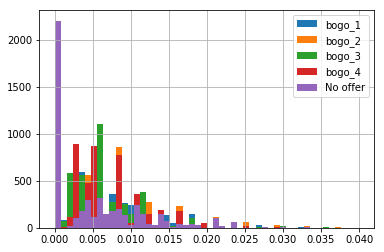

BOGO 1 mean: 0.006450805435910441
BOGO 2 mean: 0.006798231448249598
BOGO 3 mean: 0.005380281062973571
BOGO 4 mean: 0.006058094776529127
No offer mean: 0.005528949447740996


In [54]:
df[df['bogo_1'] != 0]['bogo_1_rate'].hist(bins = 50, range=(0, 0.04), label = 'bogo_1')
df[df['bogo_2'] != 0]['bogo_2_rate'].hist(bins = 50, range=(0, 0.04), label = 'bogo_2')
df[df['bogo_3'] != 0]['bogo_3_rate'].hist(bins = 50, range=(0, 0.04), label = 'bogo_3')
df[df['bogo_4'] != 0]['bogo_4_rate'].hist(bins = 50, range=(0, 0.04), label = 'bogo_4')
df[(df['bogo_1'] != 0) ]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
plt.legend()
plt.show()

bogo_1 = df[df['bogo_1'] != 0]['bogo_1_rate'].mean()
print('BOGO 1 mean: ' + str(bogo_1))
bogo_2 = df[df['bogo_2'] != 0]['bogo_2_rate'].mean()
print('BOGO 2 mean: ' + str(bogo_2))
bogo_3 = df[df['bogo_3'] != 0]['bogo_3_rate'].mean()
print('BOGO 3 mean: ' + str(bogo_3))
bogo_4 = df[df['bogo_4'] != 0]['bogo_4_rate'].mean()
print('BOGO 4 mean: ' + str(bogo_4))
no_offer = df[(df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0)| (df['bogo_4'] != 0) ]['no_offer_rate'].mean()
print('No offer mean: ' + str(no_offer))

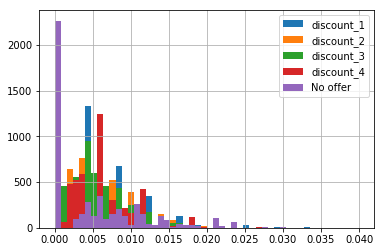

Discount 1 mean: 0.0057953125177534525
Discount 2 mean: 0.005688386683597309
Discount 3 mean: 0.005408237310011791
discount 4 mean: 0.005559127518606732
No offer mean: 0.005497164687255209


In [55]:
df[df['discount_1'] != 0]['discount_1_rate'].hist(bins = 50, range=(0, 0.04), label = 'discount_1')
df[df['discount_2'] != 0]['discount_2_rate'].hist(bins = 50, range=(0, 0.04), label = 'discount_2')
df[df['discount_3'] != 0]['discount_3_rate'].hist(bins = 50, range=(0, 0.04), label = 'discount_3')
df[df['discount_4'] != 0]['discount_4_rate'].hist(bins = 50, range=(0, 0.04), label = 'discount_4')
df[(df['discount_1'] != 0) ]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
plt.legend()
plt.show()

discount_1 = df[df['discount_1'] != 0]['discount_1_rate'].mean()
print('Discount 1 mean: ' + str(discount_1))
discount_2 = df[df['discount_2'] != 0]['discount_2_rate'].mean()
print('Discount 2 mean: ' + str(discount_2))
discount_3 = df[df['discount_3'] != 0]['discount_3_rate'].mean()
print('Discount 3 mean: ' + str(discount_3))
discount_4 = df[df['discount_4'] != 0]['discount_4_rate'].mean()
print('discount 4 mean: ' + str(discount_4))
no_offer = df[(df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0)| (df['discount_4'] != 0) ]['no_offer_rate'].mean()
print('No offer mean: ' + str(no_offer))


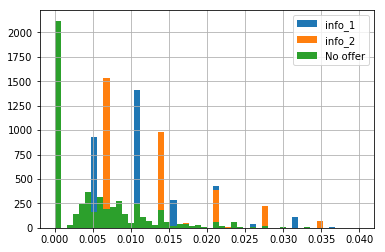

Info 1 mean: 0.007886231293748472
Info 2 mean: 0.008418918364880448
No offer mean: 0.005505725428485678


In [56]:
df[df['info_1'] != 0]['info_1_rate'].hist(bins = 50, range=(0, 0.04), label = 'info_1')
df[df['info_2'] != 0]['info_2_rate'].hist(bins = 50, range=(0, 0.04), label = 'info_2')
df[(df['info_1'] != 0) ]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
plt.legend()
plt.show()

info_1 = df[df['info_1'] != 0]['info_1_rate'].mean()
print('Info 1 mean: ' + str(info_1))
info_2 = df[df['info_2'] != 0]['info_2_rate'].mean()
print('Info 2 mean: ' + str(info_2))
no_offer = df[(df['info_1'] != 0) | (df['info_2'] != 0)]['no_offer_rate'].mean()
print('No offer mean: ' + str(no_offer))

## Conclusion 1:
All three offer types drove increased sales volume.

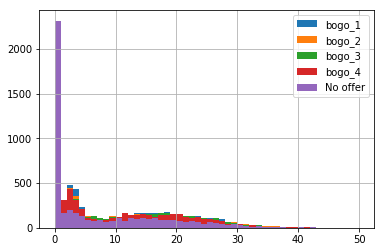

BOGO 1 mean: 13.045325520356265
BOGO 2 mean: 12.572983803174942
BOGO 3 mean: 12.211228313503545
BOGO 4 mean: 12.268041106123734
No offer mean: 8.543244660960024


In [63]:
df[df['bogo_1'] != 0]['bogo_1_avg_val'].hist(bins = 50, range=(0, 50), label = 'bogo_1')
df[df['bogo_2'] != 0]['bogo_2_avg_val'].hist(bins = 50, range=(0, 50), label = 'bogo_2')
df[df['bogo_3'] != 0]['bogo_3_avg_val'].hist(bins = 50, range=(0, 50), label = 'bogo_3')
df[df['bogo_4'] != 0]['bogo_4_avg_val'].hist(bins = 50, range=(0, 50), label = 'bogo_4')
df[(df['bogo_1'] != 0) ]['no_offer_avg_val'].hist(bins = 50, range=(0, 50), label = 'No offer')
plt.legend()
plt.show()

bogo_1 = df[df['bogo_1'] != 0]['bogo_1_avg_val'].mean()
print('BOGO 1 mean: ' + str(bogo_1))
bogo_2 = df[df['bogo_2'] != 0]['bogo_2_avg_val'].mean()
print('BOGO 2 mean: ' + str(bogo_2))
bogo_3 = df[df['bogo_3'] != 0]['bogo_3_avg_val'].mean()
print('BOGO 3 mean: ' + str(bogo_3))
bogo_4 = df[df['bogo_4'] != 0]['bogo_4_avg_val'].mean()
print('BOGO 4 mean: ' + str(bogo_4))
no_offer = df[(df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0)| (df['bogo_4'] != 0) ]['no_offer_avg_val'].mean()
print('No offer mean: ' + str(no_offer))


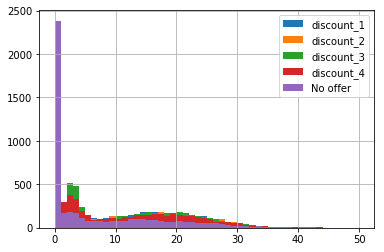

Discount 1 mean: 13.54166611059771
Discount 2 mean: 12.892788880171784
Discount 3 mean: 13.935156725933043
discount 4 mean: 12.856942789778145
No offer mean: 8.2676910907109


In [64]:
df[df['discount_1'] != 0]['discount_1_avg_val'].hist(bins = 50, range=(0, 50), label = 'discount_1')
df[df['discount_2'] != 0]['discount_2_avg_val'].hist(bins = 50, range=(0, 50), label = 'discount_2')
df[df['discount_3'] != 0]['discount_3_avg_val'].hist(bins = 50, range=(0, 50), label = 'discount_3')
df[df['discount_4'] != 0]['discount_4_avg_val'].hist(bins = 50, range=(0, 50), label = 'discount_4')
df[(df['discount_1'] != 0) ]['no_offer_avg_val'].hist(bins = 50, range=(0, 50), label = 'No offer')
plt.legend()
plt.show()

discount_1 = df[df['discount_1'] != 0]['discount_1_avg_val'].mean()
print('Discount 1 mean: ' + str(discount_1))
discount_2 = df[df['discount_2'] != 0]['discount_2_avg_val'].mean()
print('Discount 2 mean: ' + str(discount_2))
discount_3 = df[df['discount_3'] != 0]['discount_3_avg_val'].mean()
print('Discount 3 mean: ' + str(discount_3))
discount_4 = df[df['discount_4'] != 0]['discount_4_avg_val'].mean()
print('discount 4 mean: ' + str(discount_4))
no_offer = df[(df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0)| (df['discount_4'] != 0) ]['no_offer_avg_val'].mean()
print('No offer mean: ' + str(no_offer))


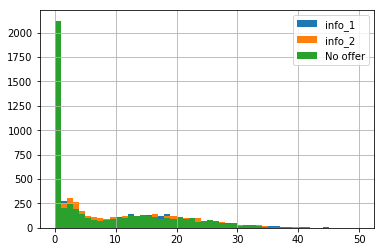

Info 1 mean: 9.869782150471803
Info 2 mean: 9.463896387412166
No offer mean: 9.026404928265848


In [65]:
df[df['info_1'] != 0]['info_1_avg_val'].hist(bins = 50, range=(0, 50), label = 'info_1')
df[df['info_2'] != 0]['info_2_avg_val'].hist(bins = 50, range=(0, 50), label = 'info_2')
df[(df['info_2'] != 0) ]['no_offer_avg_val'].hist(bins = 50, range=(0, 50), label = 'No offer')
plt.legend()
plt.show()

info_1 = df[df['info_1'] != 0]['info_1_avg_val'].mean()
print('Info 1 mean: ' + str(info_1))
info_2 = df[df['info_2'] != 0]['info_2_avg_val'].mean()
print('Info 2 mean: ' + str(info_2))
no_offer = df[(df['info_1'] != 0) | (df['info_2'] != 0)]['no_offer_avg_val'].mean()
print('No offer mean: ' + str(no_offer))


In [102]:
df_findings = pd.read_csv('demographics2.csv')

In [103]:
def set_finding(offer, demographic, col_name, val):
    '''
    Populates the findings dataframe
    Fills out a calculated value for change in transaction rate or average value
    in the row corresponding to the offer and demographic
    In: an offer id, demographic identifier, column name to put hte value in, and hte value to put in the column
    '''
    df_findings.loc[(df_findings['Offer'] == offer) & (df_findings['Demographic'] == demographic), col_name] = val



In [129]:
df_findings

,Offer,Demographic,trans_rate,avg_val,delta_trans,delta_val
0,bogo_1,gender_F,0.005634,16.145446,1.052526,1.598564
1,bogo_2,gender_F,0.005967,15.486644,1.114678,1.533336
2,bogo_3,gender_F,0.004873,15.391221,0.910246,1.523888
3,bogo_4,gender_F,0.005496,15.621004,1.026613,1.546639
4,discount_1,gender_F,0.005057,16.449484,0.953679,1.669355
5,discount_2,gender_F,0.005475,16.449272,1.032565,1.669334
6,discount_3,gender_F,0.005095,17.184143,0.960892,1.743911
7,discount_4,gender_F,0.004977,15.114310,0.938717,1.533857
8,info_1,gender_F,0.007480,12.219010,1.397130,1.127060
9,info_2,gender_F,0.008001,11.513754,1.494451,1.062008


## Breakdown by Gender
Values are:
'No_response', 'F', 'M', 'O'

Transaction rate, F, bogo_1: 0.005634396680460089
Transaction rate, F, bogo_2: 0.005967105624692851
Transaction rate, F, bogo_3: 0.004872737441403873
Transaction rate, F, bogo_4: 0.005495675598034395
Transaction rate, F, no offer: 0.005353211806736789


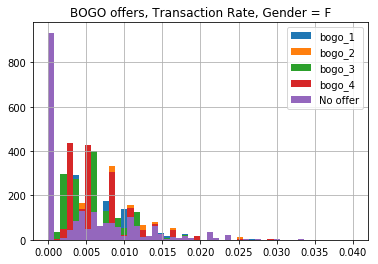

Transaction rate, M, bogo_1: 0.007023452187142654
Transaction rate, M, bogo_2: 0.007413135538135507
Transaction rate, M, bogo_3: 0.005742155732552141
Transaction rate, M, bogo_4: 0.006478328238981917
Transaction rate, M, no offer: 0.005654761369088241


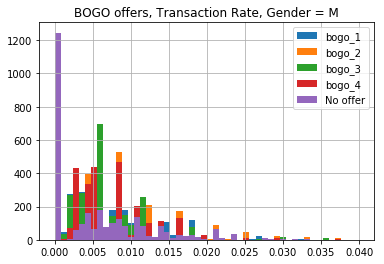

Transaction rate, O, bogo_1: 0.0069202787952787935
Transaction rate, O, bogo_2: 0.005629480286738349
Transaction rate, O, bogo_3: 0.0056236157253599095
Transaction rate, O, bogo_4: 0.005437409812409811
Transaction rate, O, no offer: 0.005586919663640868


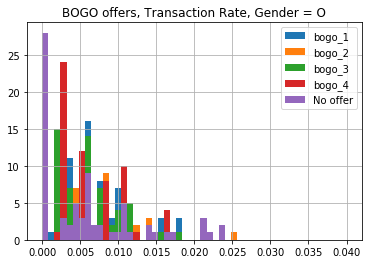

In [105]:
#BOGO -- Transactions per hour - Gender

for gend in ('F', 'M' ,'O'):
    
    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & (df['gender'] == gend)]['no_offer_rate'].mean()
    set_finding('bogo_no_offer', ('gender_' + gend), 'trans_rate', no_offer_avg)
    set_finding('bogo_no_offer', ('gender_' + gend), 'delta_trans', 1)
    
    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].mean()
        print('Transaction rate, ' + gend + ', ' + offer_name + ': ' + str(offer_avg))
        set_finding(offer_name, ('gender_' + gend), 'trans_rate', offer_avg )
        set_finding(offer_name, ('gender_' + gend), 'delta_trans', (offer_avg / no_offer_avg))
        
    df[(df['bogo_1'] != 0) & (df['gender'] == gend)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('BOGO offers, Transaction Rate, Gender = ' + gend)

    print('Transaction rate, ' + gend + ', no offer: ' + str(no_offer_avg))
    plt.show()


Transaction rate, F, bogo_1: 16.14544573773763
Transaction rate, F, bogo_2: 15.48664369783282
Transaction rate, F, bogo_3: 15.391220785472074
Transaction rate, F, bogo_4: 15.621003896637408
Avg Transaction Value, F, no offer: 10.09996565897642


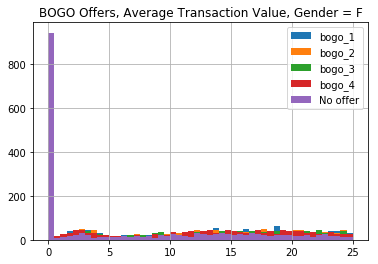

Transaction rate, M, bogo_1: 10.85762602097162
Transaction rate, M, bogo_2: 10.518503135232647
Transaction rate, M, bogo_3: 9.903239324149101
Transaction rate, M, bogo_4: 9.863846278041088
Avg Transaction Value, M, no offer: 7.4150608793248445


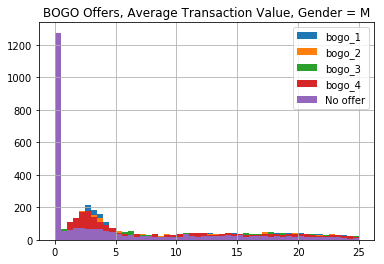

Transaction rate, O, bogo_1: 11.804145285270286
Transaction rate, O, bogo_2: 11.47766935483871
Transaction rate, O, bogo_3: 12.181815199335551
Transaction rate, O, bogo_4: 11.870439393939394
Avg Transaction Value, O, no offer: 8.58344815891473


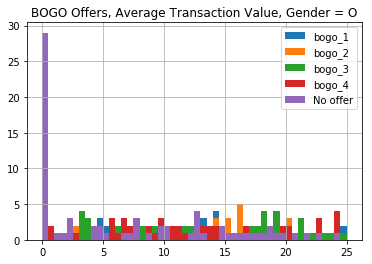

In [106]:
#BOGO -- Average Transaction Value

#No Gender specified

for gend in ('F', 'M' ,'O'):
    
    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & (df['gender'] == gend)]['no_offer_avg_val'].mean()
    set_finding('bogo_no_offer', ('gender_' + gend), 'avg_val', no_offer_avg)
    set_finding('bogo_no_offer', ('gender_' + gend), 'delta_val', 1)    
    
    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].mean()
        print('Transaction rate, ' + gend + ', ' + offer_name + ': ' + str(offer_avg))
        set_finding(offer_name, ('gender_' + gend), 'avg_val', offer_avg )
        set_finding(offer_name, ('gender_' + gend), 'delta_val', (offer_avg / no_offer_avg))
        
    df[(df['bogo_1'] != 0) & (df['gender'] == gend)]['no_offer_avg_val'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('BOGO Offers, Average Transaction Value, Gender = ' + gend)
    

    print('Avg Transaction Value, ' + gend + ', no offer: ' + str(no_offer_avg))
    plt.show()



#### Observation: Based on data plots, there is a ender-based distinction on average transaction value for BOGOs.

Transaction rate, F, discount_1: 0.005056655294750504
Transaction rate, F, discount_2: 0.005474926601129839
Transaction rate, F, discount_3: 0.005094899405821723
Transaction rate, F, discount_4: 0.004977321134487738
Transaction rate, F, no offer: 0.005302259250266864


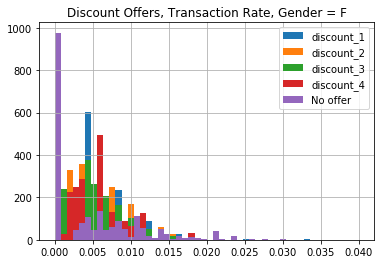

Transaction rate, M, discount_1: 0.006342339897174755
Transaction rate, M, discount_2: 0.005836746764952107
Transaction rate, M, discount_3: 0.005630381136759497
Transaction rate, M, discount_4: 0.005997408865236518
Transaction rate, M, no offer: 0.005643302085396189


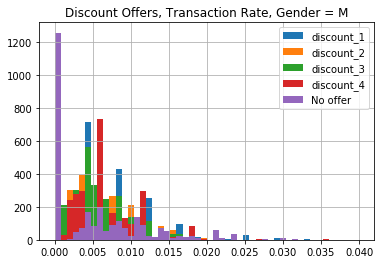

Transaction rate, O, discount_1: 0.005564960832817973
Transaction rate, O, discount_2: 0.0058274544385655495
Transaction rate, O, discount_3: 0.005318608539094651
Transaction rate, O, discount_4: 0.004746955859969555
Transaction rate, O, no offer: 0.005377723228280292


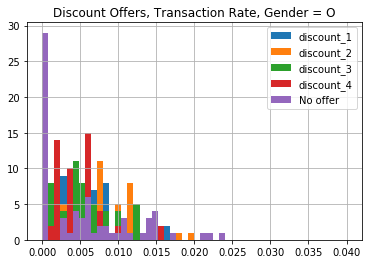

In [107]:
#Discount -- Transactions per hour

for gend in ('F', 'M' ,'O'):
    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0) | (df['discount_4'] != 0))  & (df['gender'] == gend)]['no_offer_rate'].mean()
    set_finding('discount_no_offer', ('gender_' + gend), 'trans_rate', no_offer_avg)
    set_finding('discount_no_offer', ('gender_' + gend), 'delta_trans', 1)    
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].mean()
        print('Transaction rate, ' + gend + ', ' + offer_name + ': ' + str(offer_avg))
        set_finding(offer_name, ('gender_' + gend), 'trans_rate', offer_avg )
        set_finding(offer_name, ('gender_' + gend), 'delta_trans', (offer_avg / no_offer_avg))
        
        
    df[(df['discount_1'] != 0) & (df['gender'] == gend)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Discount Offers, Transaction Rate, Gender = ' + gend)
        

    print('Transaction rate, ' + gend + ', no offer: ' + str(no_offer_avg))
    plt.show()
    

Agerage Transaction Value, F, discount_1: 16.449484287899132
Agerage Transaction Value, F, discount_2: 16.449272257410367
Agerage Transaction Value, F, discount_3: 17.184142697404738
Agerage Transaction Value, F, discount_4: 15.11431011915485
Avg Transaction Value, F, no offer: 9.853793647624135


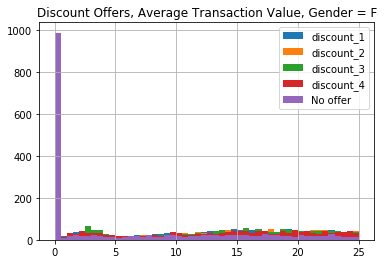

Agerage Transaction Value, M, discount_1: 11.30427687111107
Agerage Transaction Value, M, discount_2: 10.32967255382526
Agerage Transaction Value, M, discount_3: 11.69778192572806
Agerage Transaction Value, M, discount_4: 11.249734160121662
Avg Transaction Value, M, no offer: 7.10372922995272


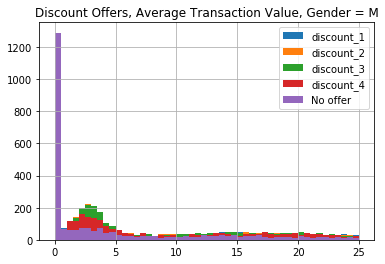

Agerage Transaction Value, O, discount_1: 17.915349360956505
Agerage Transaction Value, O, discount_2: 14.147754997060556
Agerage Transaction Value, O, discount_3: 11.917271785313451
Agerage Transaction Value, O, discount_4: 11.992730643785443
Avg Transaction Value, O, no offer: 8.231751461988301


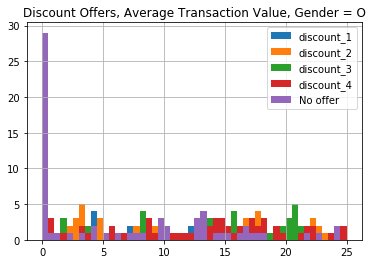

In [108]:
#Discount -- Transactions, average value

#No Gender specified

for gend in ('F', 'M' ,'O'):
        
    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0) | (df['discount_4'] != 0))  & (df['gender'] == gend)]['no_offer_avg_val'].mean()
    set_finding('discount_no_offer', ('gender_' + gend), 'avg_val', no_offer_avg)
    set_finding('discount_no_offer', ('gender_' + gend), 'delta_val', 1)  
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].mean()
        print('Agerage Transaction Value, ' + gend + ', ' + offer_name + ': ' + str(offer_avg))
        set_finding(offer_name, ('gender_' + gend), 'avg_val', offer_avg )
        set_finding(offer_name, ('gender_' + gend), 'delta_val', (offer_avg / no_offer_avg))
        
        
    df[(df['discount_1'] != 0) & (df['gender'] == gend)]['no_offer_avg_val'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Discount Offers, Average Transaction Value, Gender = ' + gend)
    
    print('Avg Transaction Value, ' + gend + ', no offer: ' + str(no_offer_avg))
    plt.show()


Transaction rate, F, info_1: 0.007479543026418022
Transaction rate, F, info_2: 0.008000551003415297
Transaction rate, F, no offer: 0.005353506435461285


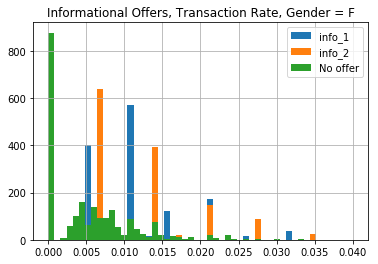

Transaction rate, M, info_1: 0.008206715530903293
Transaction rate, M, info_2: 0.008730529456426194
Transaction rate, M, no offer: 0.0056275074681869375


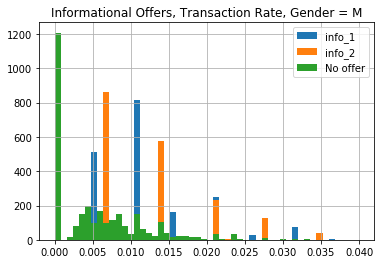

Transaction rate, O, info_1: 0.0068908607681755826
Transaction rate, O, info_2: 0.00835591689250225
Transaction rate, O, no offer: 0.005056214946136781


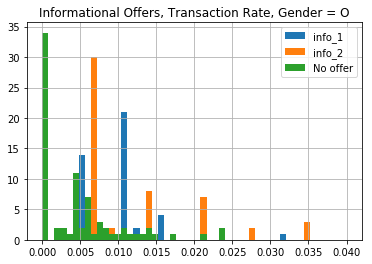

In [109]:
#Info -- Transactions per hour

for gend in ('F', 'M' ,'O'):
                
    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & (df['gender'] == gend)]['no_offer_rate'].mean()
    set_finding('info_no_offer', ('gender_' + gend), 'trans_rate', no_offer_avg)
    set_finding('info_no_offer', ('gender_' + gend), 'delta_trans', 1)     
    
    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].mean()
        print('Transaction rate, ' + gend + ', ' + offer_name + ': ' + str(offer_avg))
        set_finding(offer_name, ('gender_' + gend), 'trans_rate', offer_avg )
        set_finding(offer_name, ('gender_' + gend), 'delta_trans', (offer_avg / no_offer_avg))

    df[(df['info_1'] != 0) & (df['gender'] == gend)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Informational Offers, Transaction Rate, Gender = ' + gend)
    
    print('Transaction rate, ' + gend + ', no offer: ' + str(no_offer_avg))
    plt.show()

Average Transaction Value, F, info_1: 12.219009943181845
Average Transaction Value, F, info_2: 11.513753853306714
Average Transaction Value, F, no offer: 10.84149032921809


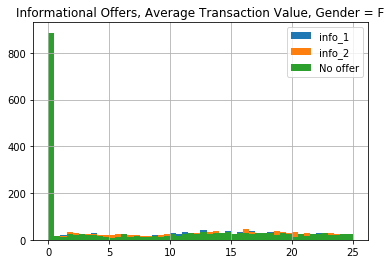

Average Transaction Value, M, info_1: 8.124885575931382
Average Transaction Value, M, info_2: 7.973491631428921
Average Transaction Value, M, no offer: 7.7321356208218575


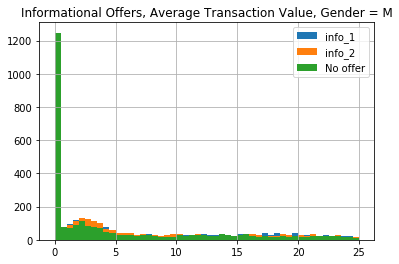

Average Transaction Value, O, info_1: 11.47614638447972
Average Transaction Value, O, info_2: 8.38735162601626
Average Transaction Value, O, no offer: 7.955697154471544


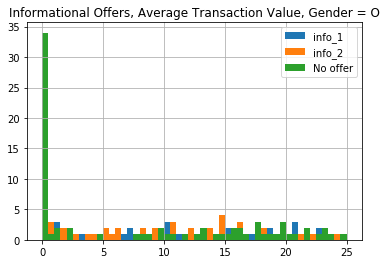

In [110]:
#Info -- Gender - Avg Value

#No Gender specified

for gend in ('F', 'M' ,'O'):
                
    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & (df['gender'] == gend)]['no_offer_avg_val'].mean()
    set_finding('info_no_offer', ('gender_' + gend), 'avg_val', no_offer_avg)
    set_finding('info_no_offer', ('gender_' + gend), 'delta_val', 1) 

    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & (df['gender'] == gend)][data_col].mean()
        print('Average Transaction Value, ' + gend + ', ' + offer_name + ': ' + str(offer_avg))  
        set_finding(offer_name, ('gender_' + gend), 'avg_val', offer_avg )
        set_finding(offer_name, ('gender_' + gend), 'delta_val', (offer_avg / no_offer_avg))
        
    df[(df['info_1'] != 0) & (df['gender'] == gend)]['no_offer_avg_val'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Informational Offers, Average Transaction Value, Gender = ' + gend)
    
    print('Average Transaction Value, ' + gend + ', no offer: ' + str(no_offer_avg))
    plt.show()

## Income

Transaction rate, income $20000 - $30000, bogo_1: 0.012946428571428574
Transaction rate, income $20000 - $30000, bogo_2: 0.010627777777777778
Transaction rate, income $20000 - $30000, bogo_3: 0.006944444444444441
Transaction rate, income $20000 - $30000, bogo_4: 0.007200854700854702
Transaction rate, Income = $20000 - $30000, no offer: 0.005525478488619997


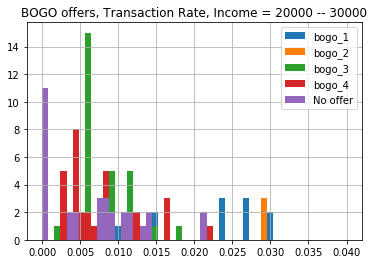

Transaction rate, income $30000 - $40000, bogo_1: 0.009222255717195885
Transaction rate, income $30000 - $40000, bogo_2: 0.00969252036453727
Transaction rate, income $30000 - $40000, bogo_3: 0.007454215386236038
Transaction rate, income $30000 - $40000, bogo_4: 0.008130078261303056
Transaction rate, Income = $30000 - $40000, no offer: 0.006587887474506726


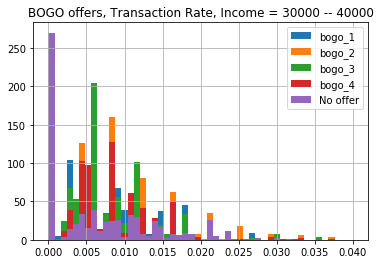

Transaction rate, income $40000 - $50000, bogo_1: 0.008463006378390252
Transaction rate, income $40000 - $50000, bogo_2: 0.008806867457866116
Transaction rate, income $40000 - $50000, bogo_3: 0.006640558439175317
Transaction rate, income $40000 - $50000, bogo_4: 0.00780588867849548
Transaction rate, Income = $40000 - $50000, no offer: 0.006207954644022544


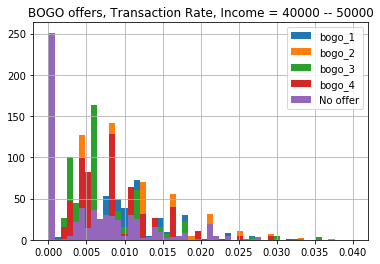

Transaction rate, income $50000 - $60000, bogo_1: 0.0070644636720668215
Transaction rate, income $50000 - $60000, bogo_2: 0.007340409786226373
Transaction rate, income $50000 - $60000, bogo_3: 0.005780979392090555
Transaction rate, income $50000 - $60000, bogo_4: 0.006583002970662805
Transaction rate, Income = $50000 - $60000, no offer: 0.005883557859206834


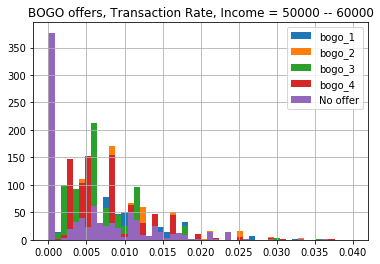

Transaction rate, income $60000 - $70000, bogo_1: 0.006893412239407108
Transaction rate, income $60000 - $70000, bogo_2: 0.007408919232559313
Transaction rate, income $60000 - $70000, bogo_3: 0.0055834802430651635
Transaction rate, income $60000 - $70000, bogo_4: 0.006459161006450551
Transaction rate, Income = $60000 - $70000, no offer: 0.005820489641131323


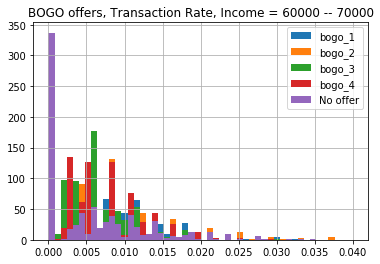

Transaction rate, income $70000 - $80000, bogo_1: 0.005185173520711448
Transaction rate, income $70000 - $80000, bogo_2: 0.005350167920191772
Transaction rate, income $70000 - $80000, bogo_3: 0.0044646825417547515
Transaction rate, income $70000 - $80000, bogo_4: 0.0049067426004844915
Transaction rate, Income = $70000 - $80000, no offer: 0.005122749244524704


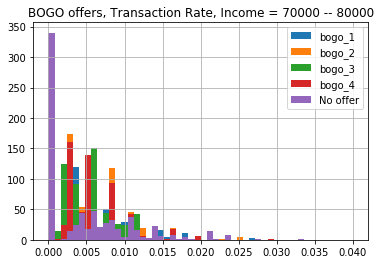

Transaction rate, income $80000 - $90000, bogo_1: 0.003778449651465514
Transaction rate, income $80000 - $90000, bogo_2: 0.0039247145497145405
Transaction rate, income $80000 - $90000, bogo_3: 0.00354905659392838
Transaction rate, income $80000 - $90000, bogo_4: 0.0038909375094843455
Transaction rate, Income = $80000 - $90000, no offer: 0.004393585316258563


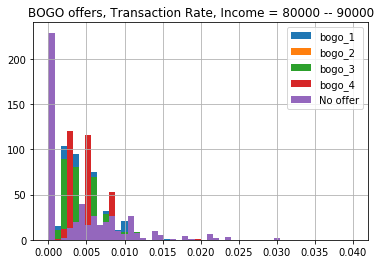

Transaction rate, income $90000 - $100000, bogo_1: 0.0038610257331578722
Transaction rate, income $90000 - $100000, bogo_2: 0.0038233588655100206
Transaction rate, income $90000 - $100000, bogo_3: 0.0035684085912396322
Transaction rate, income $90000 - $100000, bogo_4: 0.003959069037910772
Transaction rate, Income = $90000 - $100000, no offer: 0.004454718969429208


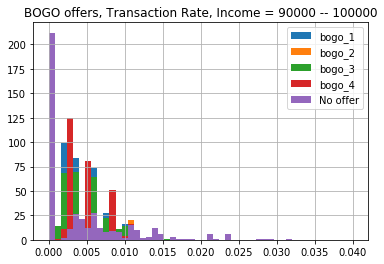

Transaction rate, income $100000 - $110000, bogo_1: 0.003597073750134968
Transaction rate, income $100000 - $110000, bogo_2: 0.004200793650793644
Transaction rate, income $100000 - $110000, bogo_3: 0.00360170897627343
Transaction rate, income $100000 - $110000, bogo_4: 0.004097977600515665
Transaction rate, Income = $100000 - $110000, no offer: 0.00426968812664393


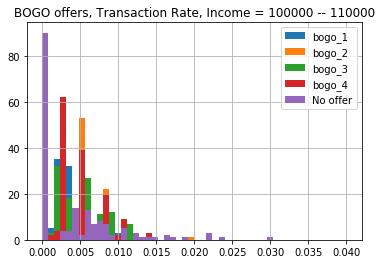

Transaction rate, income $110000 - $120000, bogo_1: 0.003346367359000332
Transaction rate, income $110000 - $120000, bogo_2: 0.004310741752681637
Transaction rate, income $110000 - $120000, bogo_3: 0.003357179361643642
Transaction rate, income $110000 - $120000, bogo_4: 0.004151011560693636
Transaction rate, Income = $110000 - $120000, no offer: 0.004135353391706424


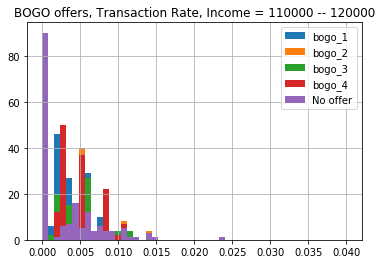

In [111]:
## Income -- BOGO -- transaction rate

for i in range(3, 13):
    income_upper = i * 10000
    income_lower = (i-1) * 10000
               
    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & ((df['income'] > income_lower) & (df['income'] <= income_upper))]['no_offer_rate'].mean()
    inc_string = 'income_' + str((i-1) * 10) + '_' + str(i * 10)
    set_finding('bogo_no_offer', inc_string, 'trans_rate', no_offer_avg)
    set_finding('bogo_no_offer', inc_string, 'delta_trans', 1)
    
    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['income'] > income_lower) & (df['income'] <= income_upper))][data_col].mean()
        print('Transaction rate, income $' + str(income_lower) + ' - $' + str(income_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, inc_string, 'trans_rate', offer_avg )
        set_finding(offer_name, inc_string, 'delta_trans', (offer_avg / no_offer_avg))

    df[(df['bogo_1'] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('BOGO offers, Transaction Rate, Income = ' + str(income_lower) + " -- " + str(income_upper))
    
    print('Transaction rate, ' + 'Income = $' + str(income_lower) + " - $" + str(income_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    
        

Average Transaction Value, income $20000 - $30000, bogo_1: 4.707979828042329
Average Transaction Value, income $20000 - $30000, bogo_2: 3.9755619047619057
Average Transaction Value, income $20000 - $30000, bogo_3: 4.046412012987013
Average Transaction Value, income $20000 - $30000, bogo_4: 4.393767806267806
Average Transaction Value, Income = $20000 - $30000, no offer: 2.9672039473684215


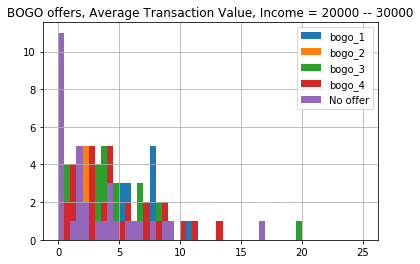

Average Transaction Value, income $30000 - $40000, bogo_1: 5.332387794032173
Average Transaction Value, income $30000 - $40000, bogo_2: 5.38440166383551
Average Transaction Value, income $30000 - $40000, bogo_3: 5.113324498138376
Average Transaction Value, income $30000 - $40000, bogo_4: 5.03782369212214
Average Transaction Value, Income = $30000 - $40000, no offer: 3.614052268188037


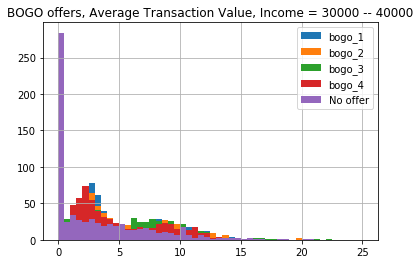

Average Transaction Value, income $40000 - $50000, bogo_1: 6.433000489458942
Average Transaction Value, income $40000 - $50000, bogo_2: 6.205191586688486
Average Transaction Value, income $40000 - $50000, bogo_3: 5.89310424285894
Average Transaction Value, income $40000 - $50000, bogo_4: 7.095626487896004
Average Transaction Value, Income = $40000 - $50000, no offer: 4.495462681634681


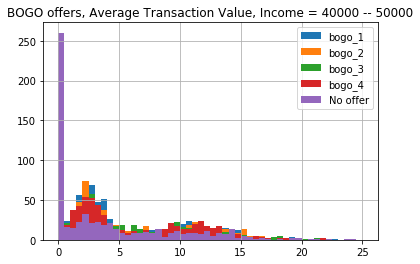

Average Transaction Value, income $50000 - $60000, bogo_1: 10.002020958517877
Average Transaction Value, income $50000 - $60000, bogo_2: 9.002343233407514
Average Transaction Value, income $50000 - $60000, bogo_3: 8.52971900194122
Average Transaction Value, income $50000 - $60000, bogo_4: 9.39513160932261
Average Transaction Value, Income = $50000 - $60000, no offer: 6.3946392985959


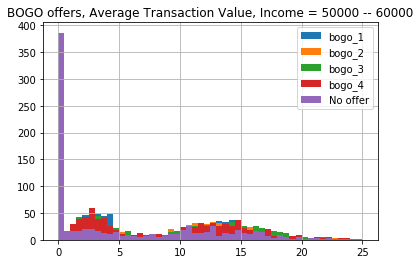

Average Transaction Value, income $60000 - $70000, bogo_1: 11.739025188567895
Average Transaction Value, income $60000 - $70000, bogo_2: 10.570879923263327
Average Transaction Value, income $60000 - $70000, bogo_3: 11.07426610597701
Average Transaction Value, income $60000 - $70000, bogo_4: 10.72992137642571
Average Transaction Value, Income = $60000 - $70000, no offer: 8.221570806759251


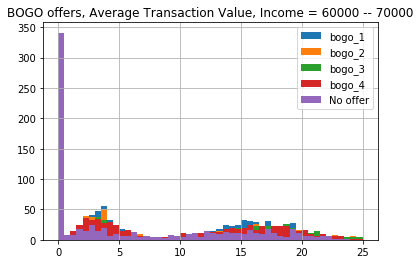

Average Transaction Value, income $70000 - $80000, bogo_1: 14.772947195294412
Average Transaction Value, income $70000 - $80000, bogo_2: 15.111928270014973
Average Transaction Value, income $70000 - $80000, bogo_3: 16.129334358142852
Average Transaction Value, income $70000 - $80000, bogo_4: 13.949128971223336
Average Transaction Value, Income = $70000 - $80000, no offer: 10.439380714945246


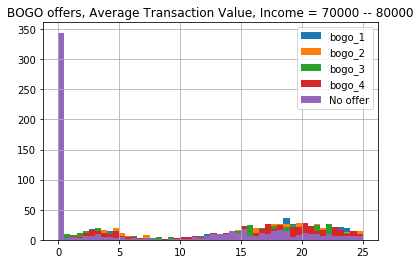

Average Transaction Value, income $80000 - $90000, bogo_1: 20.07305900740206
Average Transaction Value, income $80000 - $90000, bogo_2: 22.129195871695867
Average Transaction Value, income $80000 - $90000, bogo_3: 20.616895504780103
Average Transaction Value, income $80000 - $90000, bogo_4: 16.673111793984628
Average Transaction Value, Income = $80000 - $90000, no offer: 13.564576419863224


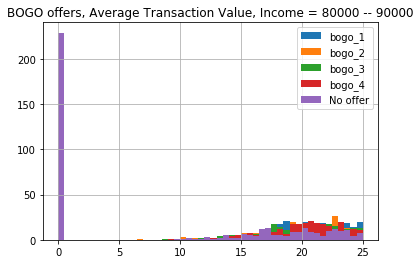

Average Transaction Value, income $90000 - $100000, bogo_1: 24.72381102783729
Average Transaction Value, income $90000 - $100000, bogo_2: 23.89136074197122
Average Transaction Value, income $90000 - $100000, bogo_3: 21.194933572515758
Average Transaction Value, income $90000 - $100000, bogo_4: 23.734441932430467
Average Transaction Value, Income = $90000 - $100000, no offer: 13.442690380184336


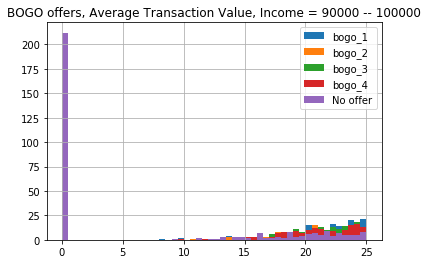

Average Transaction Value, income $100000 - $110000, bogo_1: 26.52773104056437
Average Transaction Value, income $100000 - $110000, bogo_2: 23.08875976190476
Average Transaction Value, income $100000 - $110000, bogo_3: 21.370841695702676
Average Transaction Value, income $100000 - $110000, bogo_4: 23.215799230521295
Average Transaction Value, Income = $100000 - $110000, no offer: 17.297823243647237


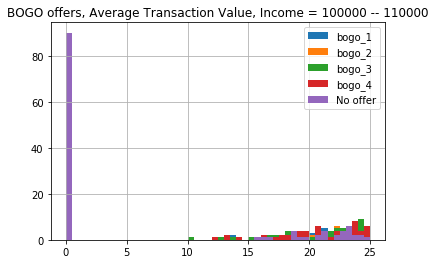

Average Transaction Value, income $110000 - $120000, bogo_1: 23.039387537993907
Average Transaction Value, income $110000 - $120000, bogo_2: 23.258628805620614
Average Transaction Value, income $110000 - $120000, bogo_3: 22.512677962662334
Average Transaction Value, income $110000 - $120000, bogo_4: 27.819987131846954
Average Transaction Value, Income = $110000 - $120000, no offer: 15.17464


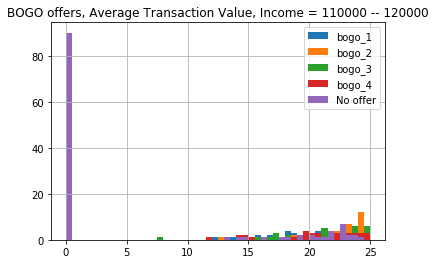

In [112]:
## Income, avg value, BOGO

for i in range(3, 13):
    income_upper = i * 10000
    income_lower = (i-1) * 10000
                
    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & ((df['income'] > income_lower) & (df['income'] <= income_upper))]['no_offer_avg_val'].mean()
    inc_string = 'income_' + str((i-1) * 10) + '_' + str(i * 10)
    set_finding('bogo_no_offer', inc_string, 'avg_val', no_offer_avg)
    set_finding('bogo_no_offer', inc_string, 'delta_val', 1)
    
    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['income'] > income_lower) & (df['income'] <= income_upper))][data_col].mean()
        print('Average Transaction Value, income $' + str(income_lower) + ' - $' + str(income_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, inc_string, 'avg_val', offer_avg )
        set_finding(offer_name, inc_string, 'delta_val', (offer_avg / no_offer_avg))         

    df[(df['bogo_1'] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)]['no_offer_avg_val'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('BOGO offers, Average Transaction Value, Income = ' + str(income_lower) + " -- " + str(income_upper))
    
    print('Average Transaction Value, ' + 'Income = $' + str(income_lower) + " - $" + str(income_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    
   

Transaction rate, income $20000 - $30000, discount_1: 0.006697530864197533
Transaction rate, income $20000 - $30000, discount_2: 0.006324404761904761
Transaction rate, income $20000 - $30000, discount_3: 0.006657088122605366
Transaction rate, income $20000 - $30000, discount_4: 0.008234126984126984
Transaction rate, Income = $20000 - $30000, no offer: 0.0057065606769648985


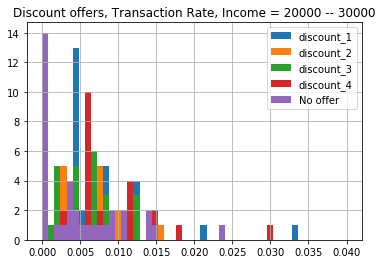

Transaction rate, income $30000 - $40000, discount_1: 0.008277244575694218
Transaction rate, income $30000 - $40000, discount_2: 0.007491441853072301
Transaction rate, income $30000 - $40000, discount_3: 0.006945531172103713
Transaction rate, income $30000 - $40000, discount_4: 0.007287341465841701
Transaction rate, Income = $30000 - $40000, no offer: 0.0065984519782780835


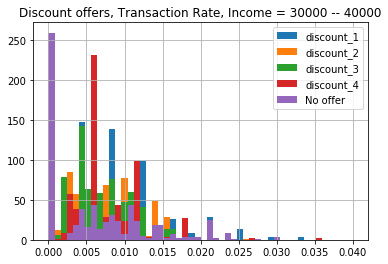

Transaction rate, income $40000 - $50000, discount_1: 0.007577080900480117
Transaction rate, income $40000 - $50000, discount_2: 0.006975464687299446
Transaction rate, income $40000 - $50000, discount_3: 0.006921196087862788
Transaction rate, income $40000 - $50000, discount_4: 0.0074470187889195995
Transaction rate, Income = $40000 - $50000, no offer: 0.006214946354795803


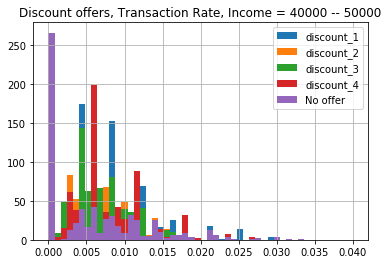

Transaction rate, income $50000 - $60000, discount_1: 0.006149090107423463
Transaction rate, income $50000 - $60000, discount_2: 0.0058830561837480465
Transaction rate, income $50000 - $60000, discount_3: 0.005685810833037306
Transaction rate, income $50000 - $60000, discount_4: 0.005825075277904836
Transaction rate, Income = $50000 - $60000, no offer: 0.005933057912078064


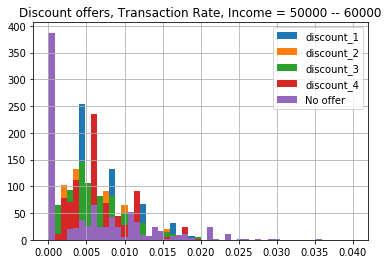

Transaction rate, income $60000 - $70000, discount_1: 0.006263832429991
Transaction rate, income $60000 - $70000, discount_2: 0.005924290323808173
Transaction rate, income $60000 - $70000, discount_3: 0.005676397604692202
Transaction rate, income $60000 - $70000, discount_4: 0.005917579811642711
Transaction rate, Income = $60000 - $70000, no offer: 0.0056918584488025855


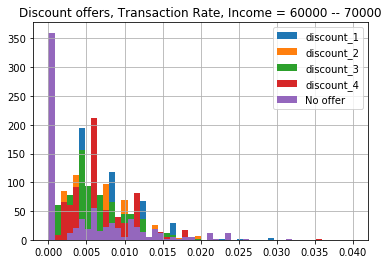

Transaction rate, income $70000 - $80000, discount_1: 0.0046878071224596045
Transaction rate, income $70000 - $80000, discount_2: 0.004881430449758079
Transaction rate, income $70000 - $80000, discount_3: 0.004593347484066534
Transaction rate, income $70000 - $80000, discount_4: 0.0047317397639971195
Transaction rate, Income = $70000 - $80000, no offer: 0.0050518305364753244


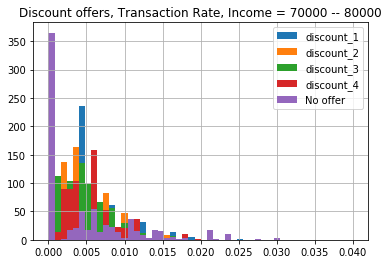

Transaction rate, income $80000 - $90000, discount_1: 0.0036302064685523362
Transaction rate, income $80000 - $90000, discount_2: 0.004169033354082362
Transaction rate, income $80000 - $90000, discount_3: 0.0038488640356316066
Transaction rate, income $80000 - $90000, discount_4: 0.003610782193657642
Transaction rate, Income = $80000 - $90000, no offer: 0.004310092463914752


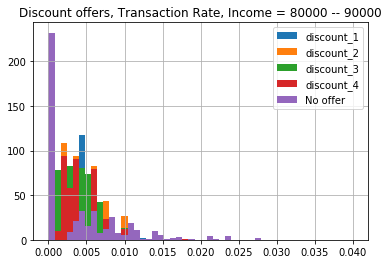

Transaction rate, income $90000 - $100000, discount_1: 0.0033179767340726233
Transaction rate, income $90000 - $100000, discount_2: 0.004148561086140794
Transaction rate, income $90000 - $100000, discount_3: 0.0036201525054466157
Transaction rate, income $90000 - $100000, discount_4: 0.003651200144140334
Transaction rate, Income = $90000 - $100000, no offer: 0.004365726397502895


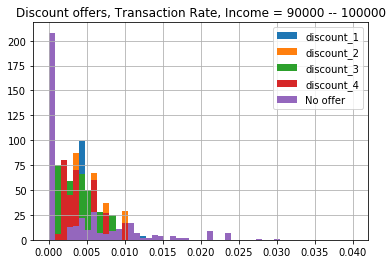

Transaction rate, income $100000 - $110000, discount_1: 0.0034070932539682504
Transaction rate, income $100000 - $110000, discount_2: 0.004188220933503944
Transaction rate, income $100000 - $110000, discount_3: 0.003891903531438407
Transaction rate, income $100000 - $110000, discount_4: 0.003549332611832604
Transaction rate, Income = $100000 - $110000, no offer: 0.004295028914929005


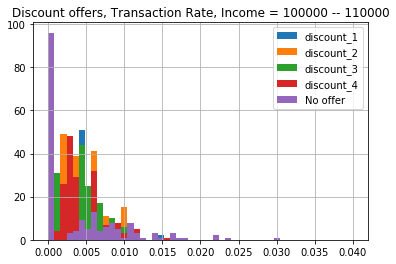

Transaction rate, income $110000 - $120000, discount_1: 0.0036853079555175315
Transaction rate, income $110000 - $120000, discount_2: 0.004349632762461704
Transaction rate, income $110000 - $120000, discount_3: 0.00401504629629629
Transaction rate, income $110000 - $120000, discount_4: 0.00334302325581395
Transaction rate, Income = $110000 - $120000, no offer: 0.004156424185797076


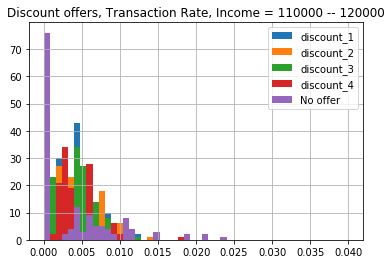

In [113]:
#Income, transaction rate, discount

for i in range(3, 13):
    income_upper = i * 10000
    income_lower = (i-1) * 10000
    
    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0) | (df['discount_4'] != 0))  & ((df['income'] > income_lower) & (df['income'] <= income_upper))]['no_offer_rate'].mean()
    inc_string = 'income_' + str((i-1) * 10) + '_' + str(i * 10)
    set_finding('discount_no_offer', inc_string, 'trans_rate', no_offer_avg)
    set_finding('discount_no_offer', inc_string, 'delta_trans', 1)
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['income'] > income_lower) & (df['income'] <= income_upper))][data_col].mean()
        print('Transaction rate, income $' + str(income_lower) + ' - $' + str(income_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, inc_string, 'trans_rate', offer_avg )
        set_finding(offer_name, inc_string, 'delta_trans', (offer_avg / no_offer_avg))        

    df[(df['discount_1'] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Discount offers, Transaction Rate, Income = ' + str(income_lower) + " -- " + str(income_upper))
            
    print('Transaction rate, ' + 'Income = $' + str(income_lower) + " - $" + str(income_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()

Average Transaction Value, income $20000 - $30000, discount_1: 3.3669708994709
Average Transaction Value, income $20000 - $30000, discount_2: 4.683254676870748
Average Transaction Value, income $20000 - $30000, discount_3: 4.4350459770114945
Average Transaction Value, income $20000 - $30000, discount_4: 4.1249
Average Transaction Value, Income = $20000 - $30000, no offer: 3.0134166666666666


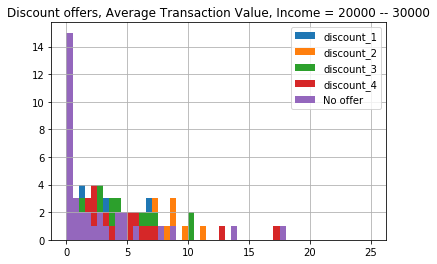

Average Transaction Value, income $30000 - $40000, discount_1: 5.473665426998818
Average Transaction Value, income $30000 - $40000, discount_2: 5.6912754451314065
Average Transaction Value, income $30000 - $40000, discount_3: 5.492540887469331
Average Transaction Value, income $30000 - $40000, discount_4: 5.680225182028379
Average Transaction Value, Income = $30000 - $40000, no offer: 3.519857055375739


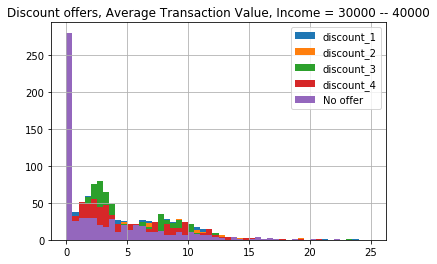

Average Transaction Value, income $40000 - $50000, discount_1: 6.612374945936595
Average Transaction Value, income $40000 - $50000, discount_2: 6.194009661618661
Average Transaction Value, income $40000 - $50000, discount_3: 6.995999710375394
Average Transaction Value, income $40000 - $50000, discount_4: 6.862503376562989
Average Transaction Value, Income = $40000 - $50000, no offer: 4.328399972098207


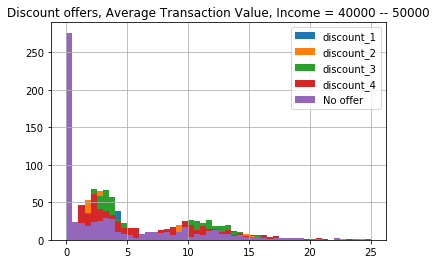

Average Transaction Value, income $50000 - $60000, discount_1: 10.918201256767924
Average Transaction Value, income $50000 - $60000, discount_2: 9.351202970046996
Average Transaction Value, income $50000 - $60000, discount_3: 9.858576059855237
Average Transaction Value, income $50000 - $60000, discount_4: 9.54079486749956
Average Transaction Value, Income = $50000 - $60000, no offer: 6.120959802385297


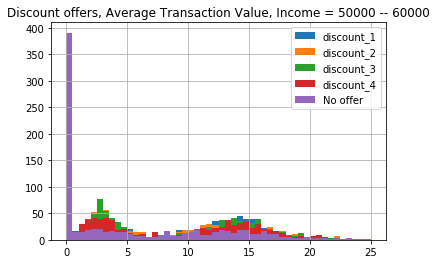

Average Transaction Value, income $60000 - $70000, discount_1: 11.862174240683828
Average Transaction Value, income $60000 - $70000, discount_2: 11.52513471339126
Average Transaction Value, income $60000 - $70000, discount_3: 11.694801578693209
Average Transaction Value, income $60000 - $70000, discount_4: 11.258243139508277
Average Transaction Value, Income = $60000 - $70000, no offer: 7.800652923777579


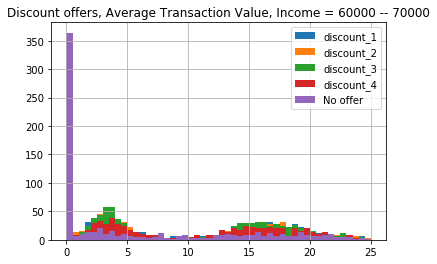

Average Transaction Value, income $70000 - $80000, discount_1: 15.009791748846956
Average Transaction Value, income $70000 - $80000, discount_2: 14.816556821588268
Average Transaction Value, income $70000 - $80000, discount_3: 17.940144460978367
Average Transaction Value, income $70000 - $80000, discount_4: 16.130992019317844
Average Transaction Value, Income = $70000 - $80000, no offer: 10.442621026213041


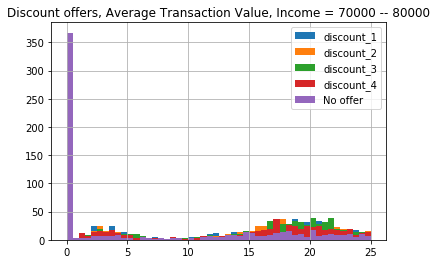

Average Transaction Value, income $80000 - $90000, discount_1: 23.10139225397097
Average Transaction Value, income $80000 - $90000, discount_2: 22.521026657329596
Average Transaction Value, income $80000 - $90000, discount_3: 23.61824508927486
Average Transaction Value, income $80000 - $90000, discount_4: 20.51938151591996
Average Transaction Value, Income = $80000 - $90000, no offer: 12.851620840895345


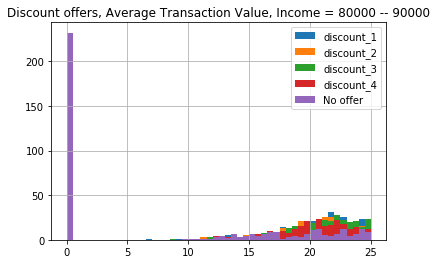

Average Transaction Value, income $90000 - $100000, discount_1: 23.16663860803073
Average Transaction Value, income $90000 - $100000, discount_2: 22.526988741850914
Average Transaction Value, income $90000 - $100000, discount_3: 24.763166886512185
Average Transaction Value, income $90000 - $100000, discount_4: 21.26256109265411
Average Transaction Value, Income = $90000 - $100000, no offer: 13.891710387367382


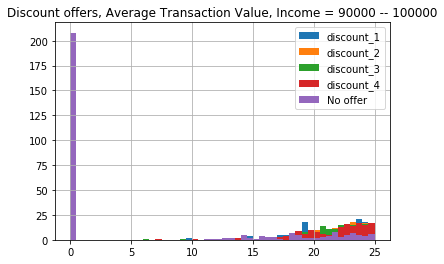

Average Transaction Value, income $100000 - $110000, discount_1: 27.7358438095238
Average Transaction Value, income $100000 - $110000, discount_2: 24.03487353998203
Average Transaction Value, income $100000 - $110000, discount_3: 27.781326581816113
Average Transaction Value, income $100000 - $110000, discount_4: 27.637183874458895
Average Transaction Value, Income = $100000 - $110000, no offer: 14.763893740902473


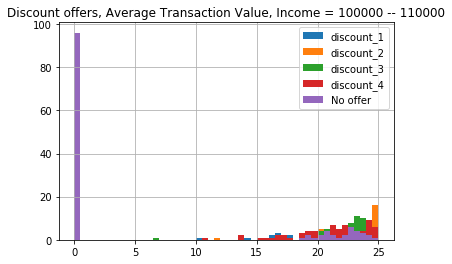

Average Transaction Value, income $110000 - $120000, discount_1: 27.572987239806114
Average Transaction Value, income $110000 - $120000, discount_2: 24.761548924394315
Average Transaction Value, income $110000 - $120000, discount_3: 24.77660196078432
Average Transaction Value, income $110000 - $120000, discount_4: 19.71989031930601
Average Transaction Value, Income = $110000 - $120000, no offer: 14.854139194139194


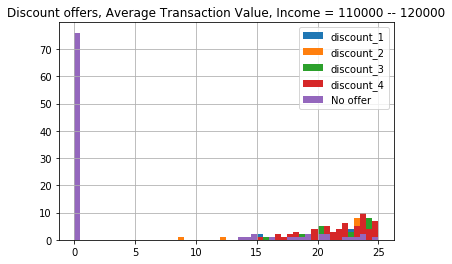

In [114]:
## Income, avg value, discount

for i in range(3, 13):
    income_upper = i * 10000
    income_lower = (i-1) * 10000
    
    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0) | (df['discount_4'] != 0))  & ((df['income'] > income_lower) & (df['income'] <= income_upper))]['no_offer_avg_val'].mean()
    inc_string = 'income_' + str((i-1) * 10) + '_' + str(i * 10)
    set_finding('discount_no_offer', inc_string, 'avg_val', no_offer_avg)
    set_finding('discount_no_offer', inc_string, 'delta_val', 1)
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['income'] > income_lower) & (df['income'] <= income_upper))][data_col].mean()
        print('Average Transaction Value, income $' + str(income_lower) + ' - $' + str(income_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, inc_string, 'avg_val', offer_avg )
        set_finding(offer_name, inc_string, 'delta_val', (offer_avg / no_offer_avg))          

    df[(df['discount_1'] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)]['no_offer_avg_val'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Discount offers, Average Transaction Value, Income = ' + str(income_lower) + " -- " + str(income_upper))
            
    print('Average Transaction Value, ' + 'Income = $' + str(income_lower) + " - $" + str(income_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    
   

Transaction rate, income $20000 - $30000, info_1: 0.012012012012012014
Transaction rate, income $20000 - $30000, info_2: 0.011885683760683762
Transaction rate, Income = $20000 - $30000, no offer: 0.00544832705202728


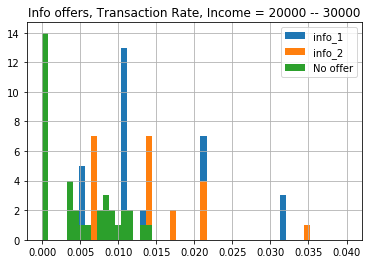

Transaction rate, income $30000 - $40000, info_1: 0.009359515765765776
Transaction rate, income $30000 - $40000, info_2: 0.01099350358422946
Transaction rate, Income = $30000 - $40000, no offer: 0.006153387463681617


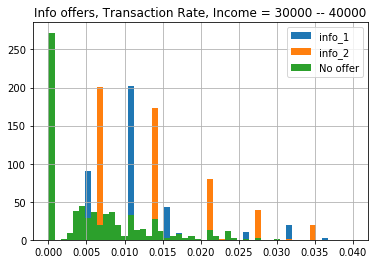

Transaction rate, income $40000 - $50000, info_1: 0.009280858763693275
Transaction rate, income $40000 - $50000, info_2: 0.010441919191919254
Transaction rate, Income = $40000 - $50000, no offer: 0.00615881966663393


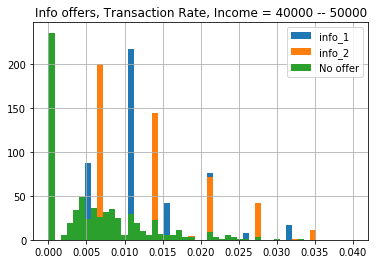

Transaction rate, income $50000 - $60000, info_1: 0.008256510416666663
Transaction rate, income $50000 - $60000, info_2: 0.009034709019856441
Transaction rate, Income = $50000 - $60000, no offer: 0.00609462159751285


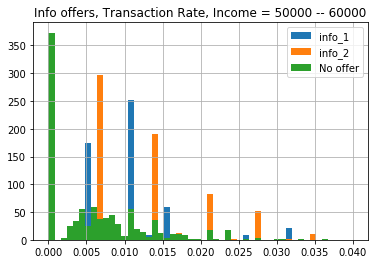

Transaction rate, income $60000 - $70000, info_1: 0.008580043859649118
Transaction rate, income $60000 - $70000, info_2: 0.008623803453211744
Transaction rate, Income = $60000 - $70000, no offer: 0.005879870974601174


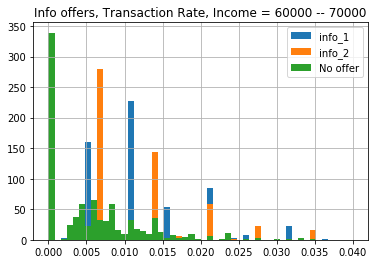

Transaction rate, income $70000 - $80000, info_1: 0.006719467226947487
Transaction rate, income $70000 - $80000, info_2: 0.0073279436152570935
Transaction rate, Income = $70000 - $80000, no offer: 0.0049862235396346275


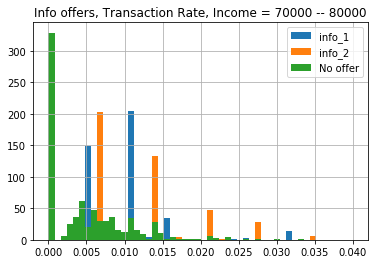

Transaction rate, income $80000 - $90000, info_1: 0.006043684591405039
Transaction rate, income $80000 - $90000, info_2: 0.005836410110763995
Transaction rate, Income = $80000 - $90000, no offer: 0.004548644459267492


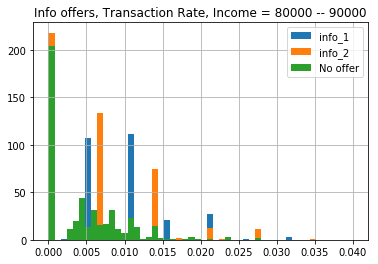

Transaction rate, income $90000 - $100000, info_1: 0.0059539098173515955
Transaction rate, income $90000 - $100000, info_2: 0.005710206995003573
Transaction rate, Income = $90000 - $100000, no offer: 0.004392634581001325


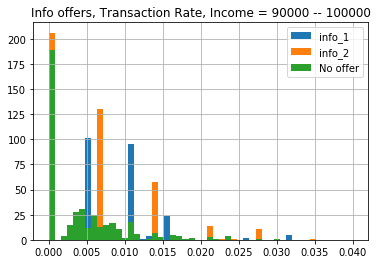

Transaction rate, income $100000 - $110000, info_1: 0.006043566887783305
Transaction rate, income $100000 - $110000, info_2: 0.005843467845955401
Transaction rate, Income = $100000 - $110000, no offer: 0.004268082973043605


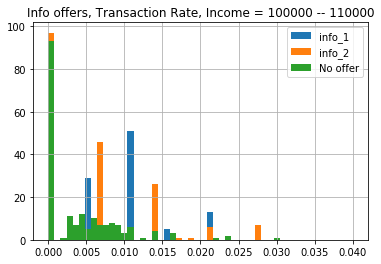

Transaction rate, income $110000 - $120000, info_1: 0.007034425813008131
Transaction rate, income $110000 - $120000, info_2: 0.006663266373718344
Transaction rate, Income = $110000 - $120000, no offer: 0.004132850199746992


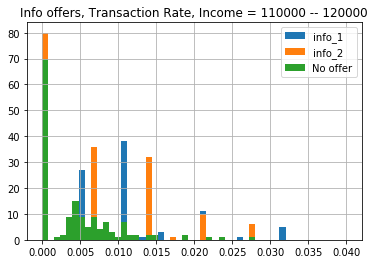

In [115]:
#Income, trans rate, Informational

for i in range(3, 13):
    income_upper = i * 10000
    income_lower = (i-1) * 10000

    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & ((df['income'] > income_lower) & (df['income'] <= income_upper))]['no_offer_rate'].mean()
    inc_string = 'income_' + str((i-1) * 10) + '_' + str(i * 10)
    set_finding('info_no_offer', inc_string, 'trans_rate', no_offer_avg)
    set_finding('info_no_offer', inc_string, 'delta_trans', 1)
    
    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['income'] > income_lower) & (df['income'] <= income_upper))][data_col].mean()
        print('Transaction rate, income $' + str(income_lower) + ' - $' + str(income_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, inc_string, 'trans_rate', offer_avg )
        set_finding(offer_name, inc_string, 'delta_trans', (offer_avg / no_offer_avg))        

    df[(df['info_1'] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Info offers, Transaction Rate, Income = ' + str(income_lower) + " -- " + str(income_upper))
            
    print('Transaction rate, ' + 'Income = $' + str(income_lower) + " - $" + str(income_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()


Average Transaction Value, income $20000 - $30000, info_1: 4.22572072072072
Average Transaction Value, income $20000 - $30000, info_2: 3.6255256410256402
Average Transaction Value, Income = $20000 - $30000, no offer: 2.702253086419754


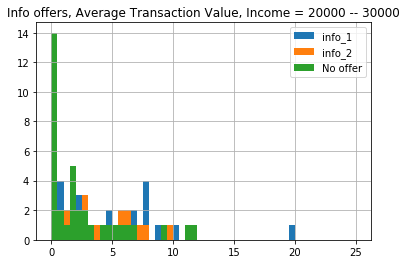

Average Transaction Value, income $30000 - $40000, info_1: 3.9089574485199488
Average Transaction Value, income $30000 - $40000, info_2: 4.364872295826937
Average Transaction Value, Income = $30000 - $40000, no offer: 3.581845884873482


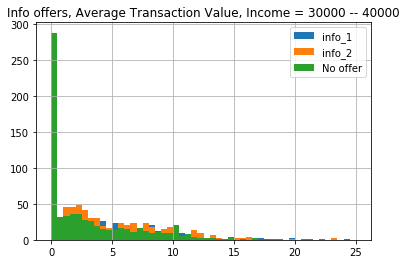

Average Transaction Value, income $40000 - $50000, info_1: 5.032085809300249
Average Transaction Value, income $40000 - $50000, info_2: 5.505549079126001
Average Transaction Value, Income = $40000 - $50000, no offer: 4.963170783686907


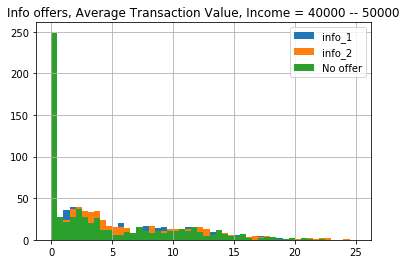

Average Transaction Value, income $50000 - $60000, info_1: 7.126261781746037
Average Transaction Value, income $50000 - $60000, info_2: 7.114255948608841
Average Transaction Value, Income = $50000 - $60000, no offer: 6.545183169834451


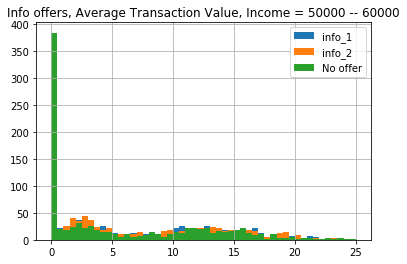

Average Transaction Value, income $60000 - $70000, info_1: 9.491481085526303
Average Transaction Value, income $60000 - $70000, info_2: 9.449051093666132
Average Transaction Value, Income = $60000 - $70000, no offer: 8.551144946445614


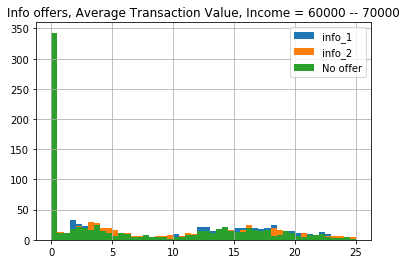

Average Transaction Value, income $70000 - $80000, info_1: 12.361991161835329
Average Transaction Value, income $70000 - $80000, info_2: 11.484574730514087
Average Transaction Value, Income = $70000 - $80000, no offer: 11.061628722600151


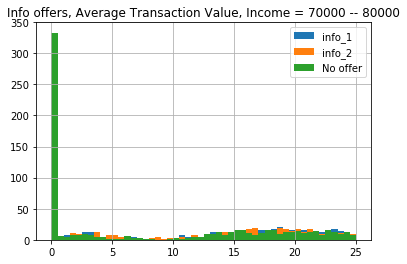

Average Transaction Value, income $80000 - $90000, info_1: 16.589332522187224
Average Transaction Value, income $80000 - $90000, info_2: 13.570193174287601
Average Transaction Value, Income = $80000 - $90000, no offer: 13.803061458333342


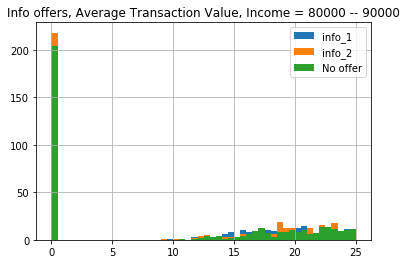

Average Transaction Value, income $90000 - $100000, info_1: 17.246057023265934
Average Transaction Value, income $90000 - $100000, info_2: 15.32112236157847
Average Transaction Value, Income = $90000 - $100000, no offer: 15.60713608776844


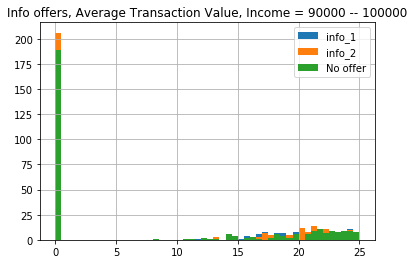

Average Transaction Value, income $100000 - $110000, info_1: 16.023146766169152
Average Transaction Value, income $100000 - $110000, info_2: 18.559160033167487
Average Transaction Value, Income = $100000 - $110000, no offer: 19.214051987767586


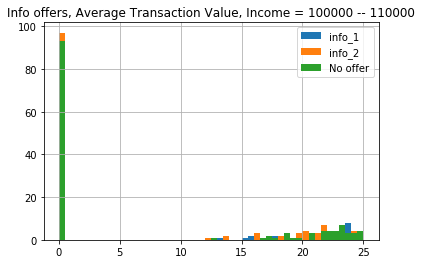

Average Transaction Value, income $110000 - $120000, info_1: 17.621962398373984
Average Transaction Value, income $110000 - $120000, info_2: 15.148858757062149
Average Transaction Value, Income = $110000 - $120000, no offer: 15.337659901599011


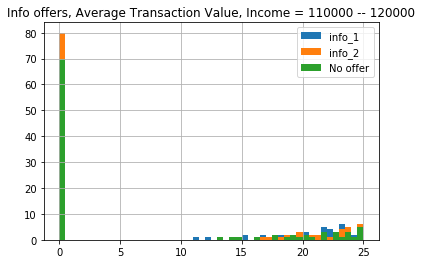

In [116]:
#Income, trans value, info

for i in range(3, 13):
    income_upper = i * 10000
    income_lower = (i-1) * 10000

    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & ((df['income'] > income_lower) & (df['income'] <= income_upper))]['no_offer_avg_val'].mean()
    inc_string = 'income_' + str((i-1) * 10) + '_' + str(i * 10)
    set_finding('info_no_offer', inc_string, 'avg_val', no_offer_avg)
    set_finding('info_no_offer', inc_string, 'delta_val', 1)
    
    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['income'] > income_lower) & (df['income'] <= income_upper))][data_col].mean()
        print('Average Transaction Value, income $' + str(income_lower) + ' - $' + str(income_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, inc_string, 'avg_val', offer_avg )
        set_finding(offer_name, inc_string, 'delta_val', (offer_avg / no_offer_avg))   

    df[(df['info_1'] != 0) & (df['income'] > income_lower) & (df['income'] <= income_upper)]['no_offer_avg_val'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Info offers, Average Transaction Value, Income = ' + str(income_lower) + " -- " + str(income_upper))
            
    print('Average Transaction Value, ' + 'Income = $' + str(income_lower) + " - $" + str(income_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()

## Member Year

Transaction rate, member joined: 2013, bogo_1: 0.012224927849927838
Transaction rate, member joined: 2013, bogo_2: 0.012078749541620826
Transaction rate, member joined: 2013, bogo_3: 0.008701769908378714
Transaction rate, member joined: 2013, bogo_4: 0.010859187109187107
Transaction rate, member joined: 2013, no offer: 0.006967957162095071


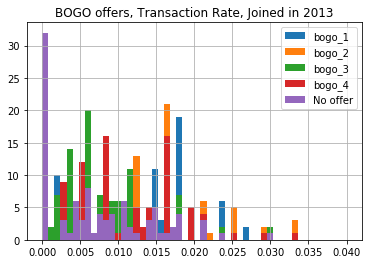

Transaction rate, member joined: 2014, bogo_1: 0.012133662989005126
Transaction rate, member joined: 2014, bogo_2: 0.012933333333333331
Transaction rate, member joined: 2014, bogo_3: 0.008653795813659744
Transaction rate, member joined: 2014, bogo_4: 0.00967306934594167
Transaction rate, member joined: 2014, no offer: 0.007132953993266568


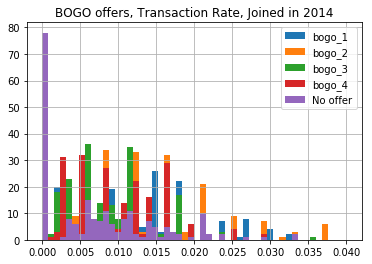

Transaction rate, member joined: 2015, bogo_1: 0.008895259889346394
Transaction rate, member joined: 2015, bogo_2: 0.009223304060073847
Transaction rate, member joined: 2015, bogo_3: 0.0072831121938264996
Transaction rate, member joined: 2015, bogo_4: 0.007932972795804662
Transaction rate, member joined: 2015, no offer: 0.006118426395260647


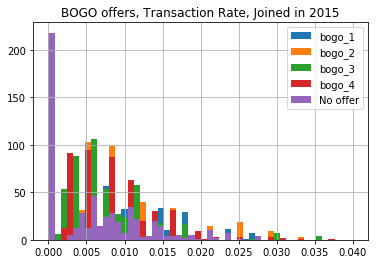

Transaction rate, member joined: 2016, bogo_1: 0.007243676056724384
Transaction rate, member joined: 2016, bogo_2: 0.007986221340388093
Transaction rate, member joined: 2016, bogo_3: 0.005986636031159488
Transaction rate, member joined: 2016, bogo_4: 0.007512233953410503
Transaction rate, member joined: 2016, no offer: 0.005858081623067881


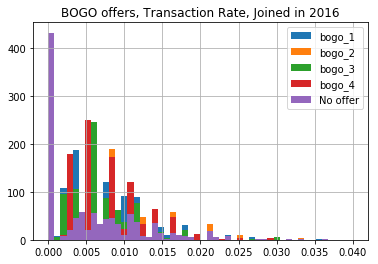

Transaction rate, member joined: 2017, bogo_1: 0.005898330221404076
Transaction rate, member joined: 2017, bogo_2: 0.006179149345796537
Transaction rate, member joined: 2017, bogo_3: 0.005084099696124445
Transaction rate, member joined: 2017, bogo_4: 0.005636925331004353
Transaction rate, member joined: 2017, no offer: 0.0053232404791527495


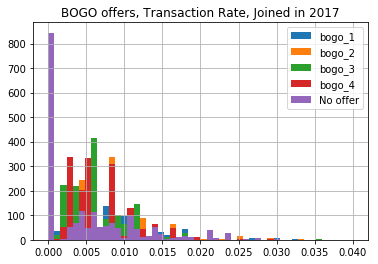

Transaction rate, member joined: 2018, bogo_1: 0.004102264243865358
Transaction rate, member joined: 2018, bogo_2: 0.004196956295871812
Transaction rate, member joined: 2018, bogo_3: 0.003648617246590257
Transaction rate, member joined: 2018, bogo_4: 0.003755568577459795
Transaction rate, member joined: 2018, no offer: 0.004916932063485708


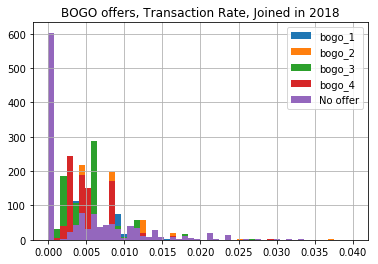

In [117]:
## Member year - transaction rate, BOGO

for i in range(2013, 2019):

    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].mean()
    set_finding('bogo_no_offer', ('joined_' + str(i)), 'trans_rate', no_offer_avg)
    set_finding('bogo_no_offer', ('joined_' + str(i)), 'delta_trans', 1)
    
    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg =  df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].mean()
        print('Transaction rate, member joined: ' + str(i) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, ('joined_' + str(i)), 'trans_rate', offer_avg )
        set_finding(offer_name, ('joined_' + str(i)), 'delta_trans', (offer_avg / no_offer_avg))  
    
    df[(df['bogo_1'] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('BOGO offers, Transaction Rate, Joined in ' + str(i))
            
    print('Transaction rate, member joined: ' + str(i) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    


Average Transaction Value, member joined: 2013, bogo_1: 6.931809412304864
Average Transaction Value, member joined: 2013, bogo_2: 8.83150110011001
Average Transaction Value, member joined: 2013, bogo_3: 7.414013368770378
Average Transaction Value, member joined: 2013, bogo_4: 6.77192324033991
Averaqge Transaction Value, member joined: 2013, no offer: 6.737023065476188


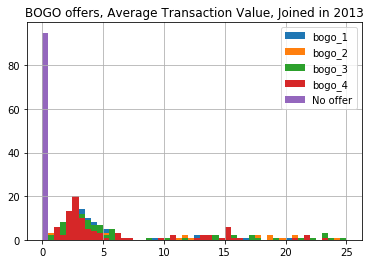

Average Transaction Value, member joined: 2014, bogo_1: 8.077932884667794
Average Transaction Value, member joined: 2014, bogo_2: 7.198420405816407
Average Transaction Value, member joined: 2014, bogo_3: 7.796327578506151
Average Transaction Value, member joined: 2014, bogo_4: 9.151472282091435
Averaqge Transaction Value, member joined: 2014, no offer: 5.933751865671645


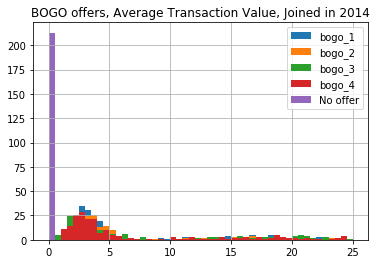

Average Transaction Value, member joined: 2015, bogo_1: 17.09994301849351
Average Transaction Value, member joined: 2015, bogo_2: 16.447570092040458
Average Transaction Value, member joined: 2015, bogo_3: 17.644418523756766
Average Transaction Value, member joined: 2015, bogo_4: 14.653508266659593
Averaqge Transaction Value, member joined: 2015, no offer: 9.189683665727294


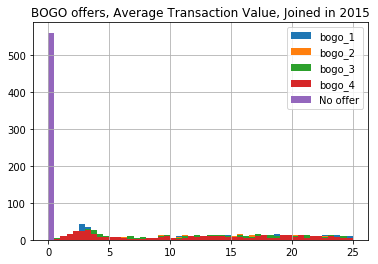

Average Transaction Value, member joined: 2016, bogo_1: 17.177222184748125
Average Transaction Value, member joined: 2016, bogo_2: 18.215397129147153
Average Transaction Value, member joined: 2016, bogo_3: 16.33261699783021
Average Transaction Value, member joined: 2016, bogo_4: 16.17171494159437
Averaqge Transaction Value, member joined: 2016, no offer: 10.088760682654703


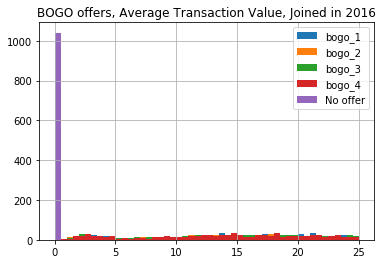

Average Transaction Value, member joined: 2017, bogo_1: 12.793420908446148
Average Transaction Value, member joined: 2017, bogo_2: 12.173331937736322
Average Transaction Value, member joined: 2017, bogo_3: 11.801707110874736
Average Transaction Value, member joined: 2017, bogo_4: 12.799060691820172
Averaqge Transaction Value, member joined: 2017, no offer: 8.734879800056039


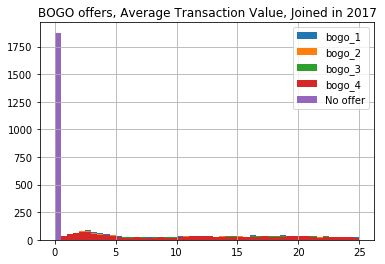

Average Transaction Value, member joined: 2018, bogo_1: 9.552832921832016
Average Transaction Value, member joined: 2018, bogo_2: 8.126537068433116
Average Transaction Value, member joined: 2018, bogo_3: 8.083720949714186
Average Transaction Value, member joined: 2018, bogo_4: 8.200927763678864
Averaqge Transaction Value, member joined: 2018, no offer: 7.285542820043987


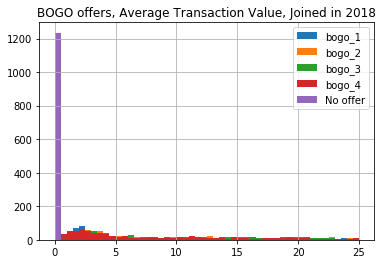

In [118]:
## Member year - transaction value, BOGO

for i in range(2013, 2019):

    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_avg_val'].mean()
    set_finding('bogo_no_offer', ('joined_' + str(i)), 'avg_val', no_offer_avg)
    set_finding('bogo_no_offer', ('joined_' + str(i)), 'delta_val', 1)
    
    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg =  df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].mean()
        print('Average Transaction Value, member joined: ' + str(i) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, ('joined_' + str(i)), 'avg_val', offer_avg )
        set_finding(offer_name, ('joined_' + str(i)), 'delta_val', (offer_avg / no_offer_avg)) 
        
    df[(df['bogo_1'] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('BOGO offers, Average Transaction Value, Joined in ' + str(i))
            
    print('Averaqge Transaction Value, member joined: ' + str(i) + ', no offer: ' + str(no_offer_avg))
    plt.show()

Transaction rate, member joined: 2013, discount_1: 0.009472634763476342
Transaction rate, member joined: 2013, discount_2: 0.008765164399092962
Transaction rate, member joined: 2013, discount_3: 0.008410961466517014
Transaction rate, member joined: 2013, discount_4: 0.00811218584656084
Transaction rate, member joined: 2013, no offer: 0.006779193951667385


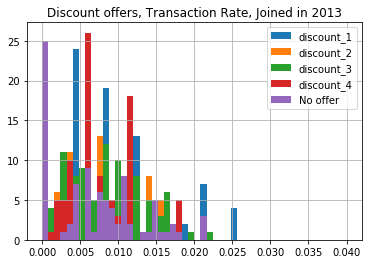

Transaction rate, member joined: 2014, discount_1: 0.009616376381940591
Transaction rate, member joined: 2014, discount_2: 0.008671280165182586
Transaction rate, member joined: 2014, discount_3: 0.007777923669467781
Transaction rate, member joined: 2014, discount_4: 0.008292664063833402
Transaction rate, member joined: 2014, no offer: 0.0070468376825930275


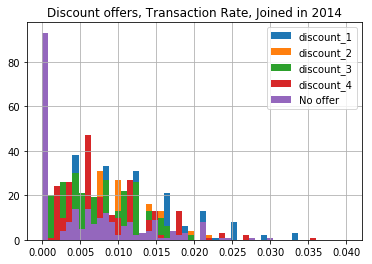

Transaction rate, member joined: 2015, discount_1: 0.006789497441093211
Transaction rate, member joined: 2015, discount_2: 0.00761113692688971
Transaction rate, member joined: 2015, discount_3: 0.00718001443001446
Transaction rate, member joined: 2015, discount_4: 0.007073585837504356
Transaction rate, member joined: 2015, no offer: 0.006157927328404593


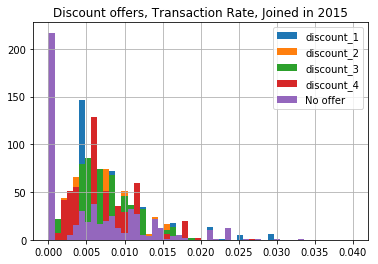

Transaction rate, member joined: 2016, discount_1: 0.006491495816092617
Transaction rate, member joined: 2016, discount_2: 0.006971913476274018
Transaction rate, member joined: 2016, discount_3: 0.006664192423640143
Transaction rate, member joined: 2016, discount_4: 0.00629260441139961
Transaction rate, member joined: 2016, no offer: 0.005830580562121019


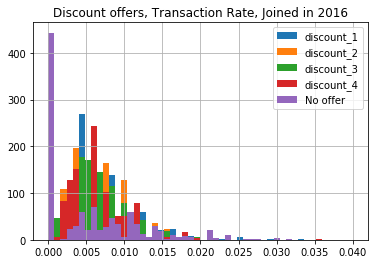

Transaction rate, member joined: 2017, discount_1: 0.005445475309067753
Transaction rate, member joined: 2017, discount_2: 0.005363205355373378
Transaction rate, member joined: 2017, discount_3: 0.005121149171285196
Transaction rate, member joined: 2017, discount_4: 0.005145349381455769
Transaction rate, member joined: 2017, no offer: 0.005288121080743708


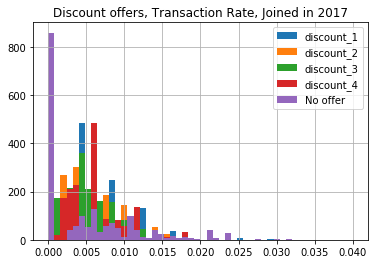

Transaction rate, member joined: 2018, discount_1: 0.004342864743248415
Transaction rate, member joined: 2018, discount_2: 0.0036646870189134223
Transaction rate, member joined: 2018, discount_3: 0.003447390739636943
Transaction rate, member joined: 2018, discount_4: 0.004243642714935385
Transaction rate, member joined: 2018, no offer: 0.0048774896963304296


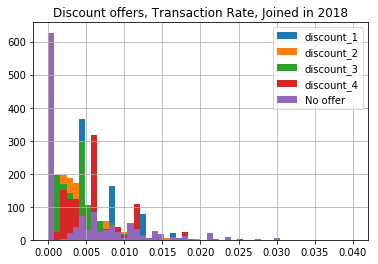

In [119]:
## Member year - transaction rate, Discount

for i in range(2013, 2019):

    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0) | (df['discount_4'] != 0))  & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].mean()
    set_finding('discount_no_offer', ('joined_' + str(i)), 'trans_rate', no_offer_avg)
    set_finding('discount_no_offer', ('joined_' + str(i)), 'delta_trans', 1)
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg =  df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].mean()
        print('Transaction rate, member joined: ' + str(i) + ', ' + offer_name + ': ' + str(offer_avg))
        set_finding(offer_name, ('joined_' + str(i)), 'trans_rate', offer_avg )
        set_finding(offer_name, ('joined_' + str(i)), 'delta_trans', (offer_avg / no_offer_avg)) 
        
    df[(df['discount_1'] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Discount offers, Transaction Rate, Joined in ' + str(i))
            
    print('Transaction rate, member joined: ' + str(i) + ', no offer: ' + str(no_offer_avg))
    plt.show()


Average Transaction Value, member joined: 2013, discount_1: 8.870046440358324
Average Transaction Value, member joined: 2013, discount_2: 9.192087803030304
Average Transaction Value, member joined: 2013, discount_3: 9.722053063472114
Average Transaction Value, member joined: 2013, discount_4: 9.223025876322751
Average Transaction Value, member joined: 2013, no offer: 6.838755980861245


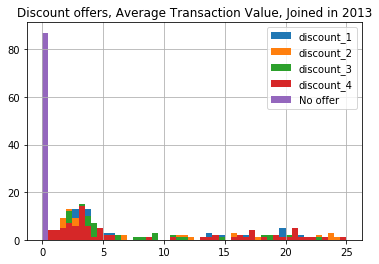

Average Transaction Value, member joined: 2014, discount_1: 8.819170333125587
Average Transaction Value, member joined: 2014, discount_2: 7.9528344988345
Average Transaction Value, member joined: 2014, discount_3: 8.705591591600376
Average Transaction Value, member joined: 2014, discount_4: 9.924437175615603
Average Transaction Value, member joined: 2014, no offer: 5.676828841793129


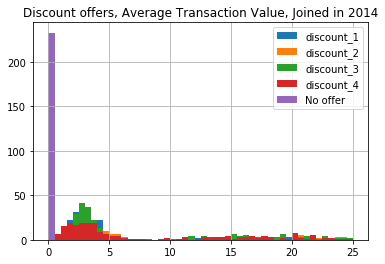

Average Transaction Value, member joined: 2015, discount_1: 15.315249364542538
Average Transaction Value, member joined: 2015, discount_2: 14.62584558158907
Average Transaction Value, member joined: 2015, discount_3: 16.022992673554274
Average Transaction Value, member joined: 2015, discount_4: 16.242439174010073
Average Transaction Value, member joined: 2015, no offer: 9.133359461249718


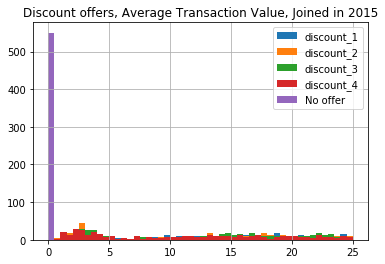

Average Transaction Value, member joined: 2016, discount_1: 18.46749747349791
Average Transaction Value, member joined: 2016, discount_2: 17.39518736082717
Average Transaction Value, member joined: 2016, discount_3: 18.7313630933514
Average Transaction Value, member joined: 2016, discount_4: 17.3720202941613
Average Transaction Value, member joined: 2016, no offer: 10.060582876579195


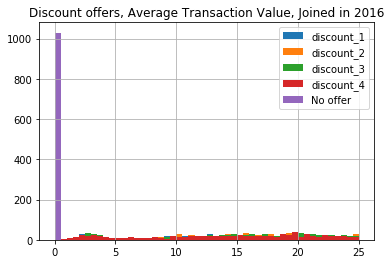

Average Transaction Value, member joined: 2017, discount_1: 13.401968922380796
Average Transaction Value, member joined: 2017, discount_2: 13.503147701581518
Average Transaction Value, member joined: 2017, discount_3: 14.022488314711175
Average Transaction Value, member joined: 2017, discount_4: 12.82076843756861
Average Transaction Value, member joined: 2017, no offer: 8.499763757547715


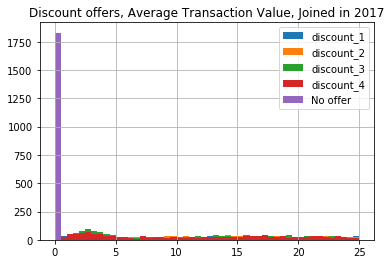

Average Transaction Value, member joined: 2018, discount_1: 10.144977985611815
Average Transaction Value, member joined: 2018, discount_2: 8.832607020884247
Average Transaction Value, member joined: 2018, discount_3: 10.498809993668827
Average Transaction Value, member joined: 2018, discount_4: 8.542477352483212
Average Transaction Value, member joined: 2018, no offer: 6.632620363683045


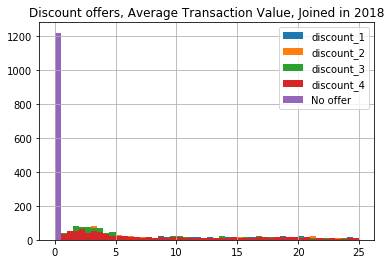

In [120]:
## Member year - transaction value, Discount

for i in range(2013, 2019):

    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0) | (df['discount_4'] != 0))  & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_avg_val'].mean()
    set_finding('discount_no_offer', ('joined_' + str(i)), 'avg_val', no_offer_avg)
    set_finding('discount_no_offer', ('joined_' + str(i)), 'delta_val', 1)
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg =  df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].mean()
        print('Average Transaction Value, member joined: ' + str(i) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, ('joined_' + str(i)), 'avg_val', offer_avg )
        set_finding(offer_name, ('joined_' + str(i)), 'delta_val', (offer_avg / no_offer_avg))  

    df[(df['discount_1'] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Discount offers, Average Transaction Value, Joined in ' + str(i))
            
    print('Average Transaction Value, member joined: ' + str(i) + ', no offer: ' + str(no_offer_avg))
    plt.show()


Transaction rate, member joined: 2013, info_1: 0.011689814814814807
Transaction rate, member joined: 2013, info_2: 0.01321277961129445
Transaction rate, member joined: 2013, no offer: 0.007073808157433638


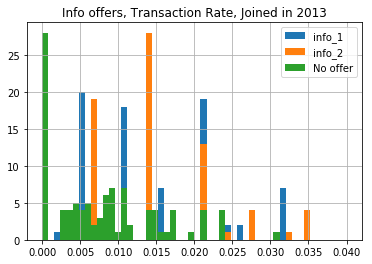

Transaction rate, member joined: 2014, info_1: 0.011473992374727671
Transaction rate, member joined: 2014, info_2: 0.012933906710057338
Transaction rate, member joined: 2014, no offer: 0.00684539386672259


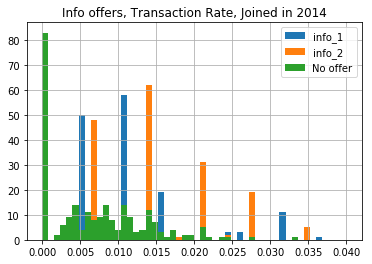

Transaction rate, member joined: 2015, info_1: 0.010020894788593917
Transaction rate, member joined: 2015, info_2: 0.011143730742627235
Transaction rate, member joined: 2015, no offer: 0.006352245845093165


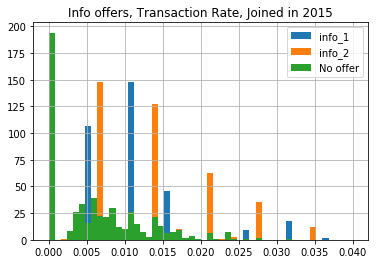

Transaction rate, member joined: 2016, info_1: 0.009813600640831565
Transaction rate, member joined: 2016, info_2: 0.010032180583908595
Transaction rate, member joined: 2016, no offer: 0.0058774650324607105


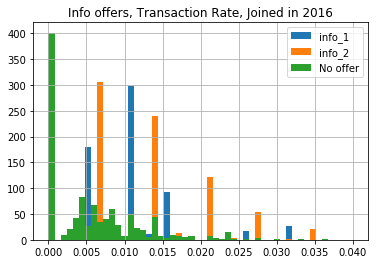

Transaction rate, member joined: 2017, info_1: 0.007309679025535499
Transaction rate, member joined: 2017, info_2: 0.007998905395229699
Transaction rate, member joined: 2017, no offer: 0.005214999792402149


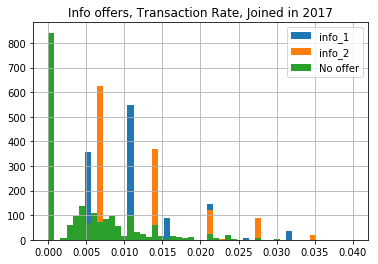

Transaction rate, member joined: 2018, info_1: 0.005409942204623633
Transaction rate, member joined: 2018, info_2: 0.005304127823969153
Transaction rate, member joined: 2018, no offer: 0.004913344080589847


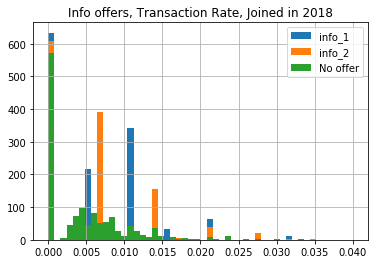

In [121]:
## Member year - transaction rate, Info

for i in range(2013, 2019):

    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].mean()
    set_finding('info_no_offer', ('joined_' + str(i)), 'trans_rate', no_offer_avg)
    set_finding('info_no_offer', ('joined_' + str(i)), 'delta_trans', 1)
    
    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg =  df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].mean()
        print('Transaction rate, member joined: ' + str(i) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, ('joined_' + str(i)), 'trans_rate', offer_avg )
        set_finding(offer_name, ('joined_' + str(i)), 'delta_trans', (offer_avg / no_offer_avg)) 
        
    df[(df['info_1'] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Info offers, Transaction Rate, Joined in ' + str(i))
 

    print('Transaction rate, member joined: ' + str(i) + ', no offer: ' + str(no_offer_avg))
    plt.show()

Average Transaction Value, member joined: 2013, info_1: 6.414543650793651
Average Transaction Value, member joined: 2013, info_2: 4.771987270155588
Average Transaction Value, member joined: 2013, no offer: 6.6010393081761


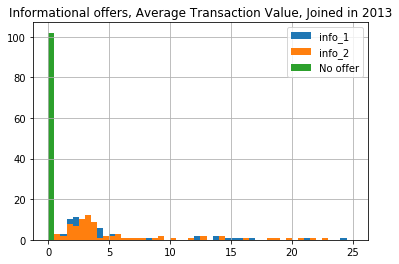

Average Transaction Value, member joined: 2014, info_1: 6.325865499533149
Average Transaction Value, member joined: 2014, info_2: 5.896492928155066
Average Transaction Value, member joined: 2014, no offer: 6.375960588023089


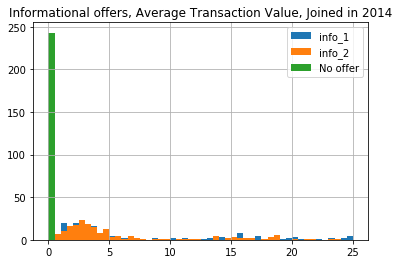

Average Transaction Value, member joined: 2015, info_1: 11.007542477876099
Average Transaction Value, member joined: 2015, info_2: 13.091449894898535
Average Transaction Value, member joined: 2015, no offer: 9.647423406399598


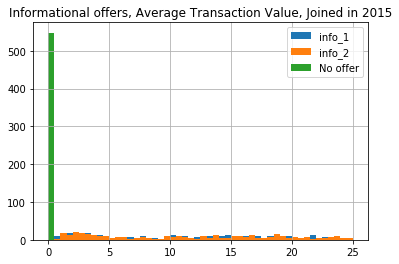

Average Transaction Value, member joined: 2016, info_1: 14.016312208958654
Average Transaction Value, member joined: 2016, info_2: 13.039297504478613
Average Transaction Value, member joined: 2016, no offer: 11.083181469516905


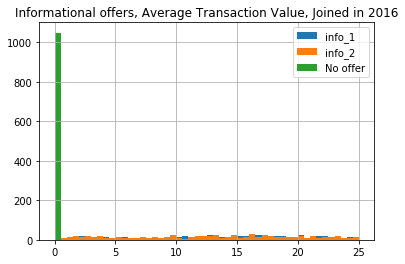

Average Transaction Value, member joined: 2017, info_1: 10.158798483923484
Average Transaction Value, member joined: 2017, info_2: 9.418242933067038
Average Transaction Value, member joined: 2017, no offer: 8.942651176061325


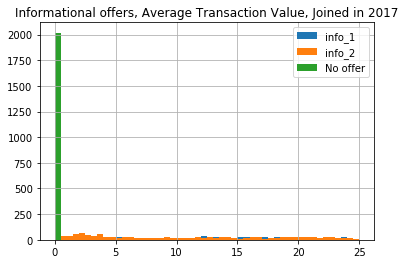

Average Transaction Value, member joined: 2018, info_1: 6.6012666186705085
Average Transaction Value, member joined: 2018, info_2: 5.83582109263458
Average Transaction Value, member joined: 2018, no offer: 7.8407108622669766


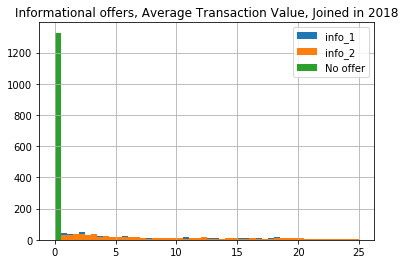

In [122]:
## Member year - transaction value, Info

for i in range(2013, 2019):

    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_avg_val'].mean()
    set_finding('info_no_offer', ('joined_' + str(i)), 'avg_val', no_offer_avg)
    set_finding('info_no_offer', ('joined_' + str(i)), 'delta_val', 1)   

    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg =  df[(df[offer_name] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)][data_col].mean()
        print('Average Transaction Value, member joined: ' + str(i) + ', ' + offer_name + ': ' + str(offer_avg))
        set_finding(offer_name, ('joined_' + str(i)), 'avg_val', offer_avg )
        set_finding(offer_name, ('joined_' + str(i)), 'delta_val', (offer_avg / no_offer_avg)) 
        
    df[(df['info_1'] != 0) & (df['date_parsed'].apply(lambda x: x.year) == i)]['no_offer_rate'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Informational offers, Average Transaction Value, Joined in ' + str(i))
  
    print('Average Transaction Value, member joined: ' + str(i) + ', no offer: ' + str(no_offer_avg))
    plt.show()


## Age

Transaction Rate, age 10 - 20, bogo_1: 0.009160808767951615
Transaction Rate, age 10 - 20, bogo_2: 0.009517053024247261
Transaction Rate, age 10 - 20, bogo_3: 0.0069056754933378255
Transaction Rate, age 10 - 20, bogo_4: 0.008293855871375244
Transaction Rate, age = 10 - 20, no offer: 0.006245271639777742


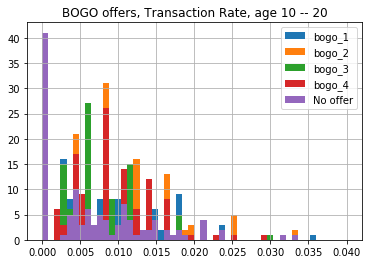

Transaction Rate, age 20 - 30, bogo_1: 0.009038701697134851
Transaction Rate, age 20 - 30, bogo_2: 0.00961740230643825
Transaction Rate, age 20 - 30, bogo_3: 0.007327178790994582
Transaction Rate, age 20 - 30, bogo_4: 0.008295197356509156
Transaction Rate, age = 20 - 30, no offer: 0.006209470670028635


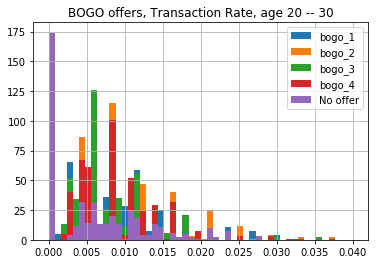

Transaction Rate, age 30 - 40, bogo_1: 0.00821506128105882
Transaction Rate, age 30 - 40, bogo_2: 0.008654165024954044
Transaction Rate, age 30 - 40, bogo_3: 0.006532850538156339
Transaction Rate, age 30 - 40, bogo_4: 0.007089453437250195
Transaction Rate, age = 30 - 40, no offer: 0.006291696819820473


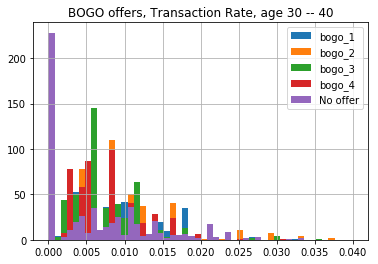

Transaction Rate, age 40 - 50, bogo_1: 0.006195844404820219
Transaction Rate, age 40 - 50, bogo_2: 0.006621506320933839
Transaction Rate, age 40 - 50, bogo_3: 0.005332488455558526
Transaction Rate, age 40 - 50, bogo_4: 0.005830541275853789
Transaction Rate, age = 40 - 50, no offer: 0.005446816622874806


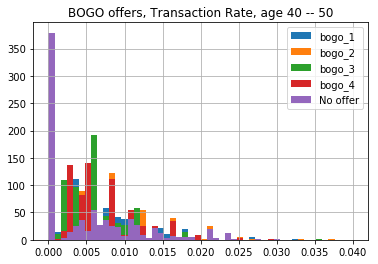

Transaction Rate, age 50 - 60, bogo_1: 0.005704980528984733
Transaction Rate, age 50 - 60, bogo_2: 0.006106623582713924
Transaction Rate, age 50 - 60, bogo_3: 0.004823999479212334
Transaction Rate, age 50 - 60, bogo_4: 0.005518777230154755
Transaction Rate, age = 50 - 60, no offer: 0.005432269054106123


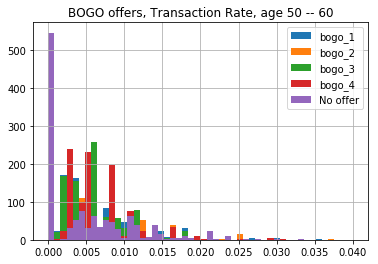

Transaction Rate, age 60 - 70, bogo_1: 0.005801668841052464
Transaction Rate, age 60 - 70, bogo_2: 0.005915487562796709
Transaction Rate, age 60 - 70, bogo_3: 0.004768033279687276
Transaction Rate, age 60 - 70, bogo_4: 0.005559559760590725
Transaction Rate, age = 60 - 70, no offer: 0.005260025122808006


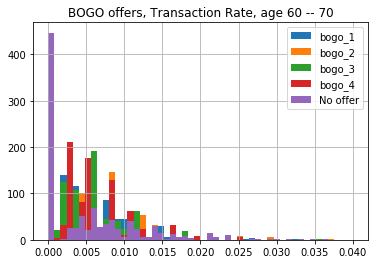

Transaction Rate, age 70 - 80, bogo_1: 0.005635994223545941
Transaction Rate, age 70 - 80, bogo_2: 0.005855018405388468
Transaction Rate, age 70 - 80, bogo_3: 0.004974113506250731
Transaction Rate, age 70 - 80, bogo_4: 0.005289071284746735
Transaction Rate, age = 70 - 80, no offer: 0.005036440433212479


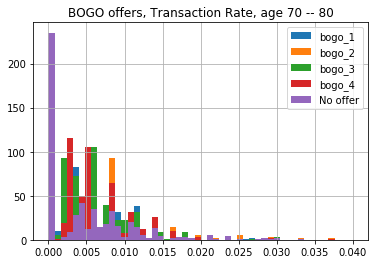

Transaction Rate, age 80 - 90, bogo_1: 0.005687952443291165
Transaction Rate, age 80 - 90, bogo_2: 0.005712325207860912
Transaction Rate, age 80 - 90, bogo_3: 0.004857944398760715
Transaction Rate, age 80 - 90, bogo_4: 0.005774224408910743
Transaction Rate, age = 80 - 90, no offer: 0.005168473724064509


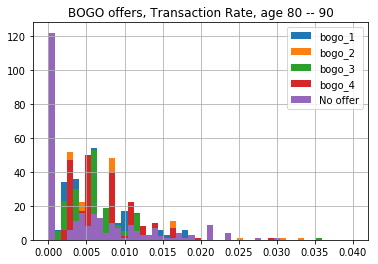

Transaction Rate, age 90 - 100, bogo_1: 0.005252230762434842
Transaction Rate, age 90 - 100, bogo_2: 0.006636408730158727
Transaction Rate, age 90 - 100, bogo_3: 0.005288999161308358
Transaction Rate, age 90 - 100, bogo_4: 0.005518617021276595
Transaction Rate, age = 90 - 100, no offer: 0.0056645717277745405


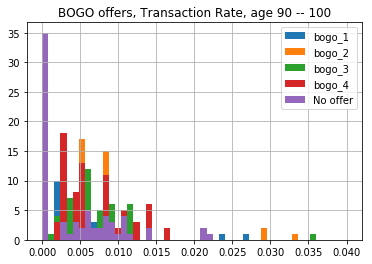

Transaction Rate, age 100 - 110, bogo_1: nan
Transaction Rate, age 100 - 110, bogo_2: nan
Transaction Rate, age 100 - 110, bogo_3: 0.003968253968253968
Transaction Rate, age 100 - 110, bogo_4: 0.002777777777777778
Transaction Rate, age = 100 - 110, no offer: 0.013888888888888888


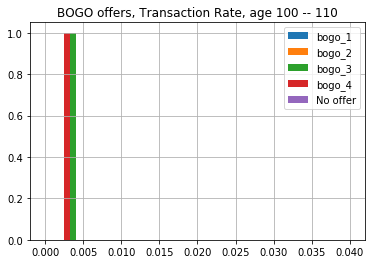

In [123]:
#age - transaction rate, bogo
for i in range(2, 12):
    age_lower = (i-1) * 10
    age_upper = i * 10

    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & ((df['age'] > age_lower) & (df['age'] <= age_upper))]['no_offer_rate'].mean()
    age_string = 'age_' + str(age_lower) + '_' + str(age_upper)
    set_finding('bogo_no_offer', age_string, 'trans_rate', no_offer_avg)
    set_finding('bogo_no_offer', age_string, 'delta_trans', 1)   

    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['age'] > age_lower) & (df['age'] <= age_upper))][data_col].mean()
        print('Transaction Rate, age ' + str(age_lower) + ' - ' + str(age_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, age_string, 'trans_rate', offer_avg )
        set_finding(offer_name, age_string, 'delta_trans', (offer_avg / no_offer_avg))      
        
    df[(df['bogo_1'] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('BOGO offers, Transaction Rate, age ' + str(age_lower) + ' -- ' + str(age_upper))
  
    print('Transaction Rate, ' + 'age = ' + str(age_lower) + " - " + str(age_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    
    
    


Average Transaction Value, age 10 - 20, bogo_1: 6.1947699901209905
Average Transaction Value, age 10 - 20, bogo_2: 5.815733995221406
Average Transaction Value, age 10 - 20, bogo_3: 5.009767235519303
Average Transaction Value, age 10 - 20, bogo_4: 5.513107173618803
Average Transaction Value, age = 10 - 20, no offer: 5.003833333333334


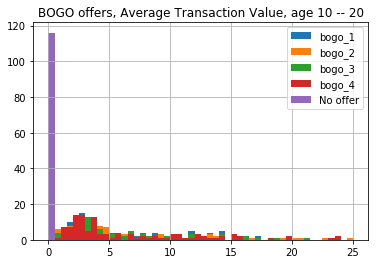

Average Transaction Value, age 20 - 30, bogo_1: 7.338142034944431
Average Transaction Value, age 20 - 30, bogo_2: 7.840010387952725
Average Transaction Value, age 20 - 30, bogo_3: 6.91016319150935
Average Transaction Value, age 20 - 30, bogo_4: 7.54791934348921
Average Transaction Value, age = 20 - 30, no offer: 4.608882521645016


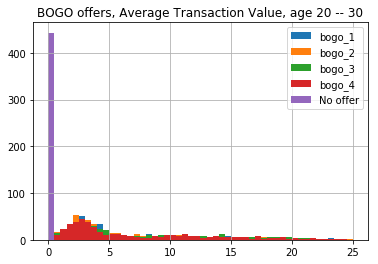

Average Transaction Value, age 30 - 40, bogo_1: 9.922868994717948
Average Transaction Value, age 30 - 40, bogo_2: 8.524253778923992
Average Transaction Value, age 30 - 40, bogo_3: 8.85641864627208
Average Transaction Value, age 30 - 40, bogo_4: 9.565746667600987
Average Transaction Value, age = 30 - 40, no offer: 6.036774376417235


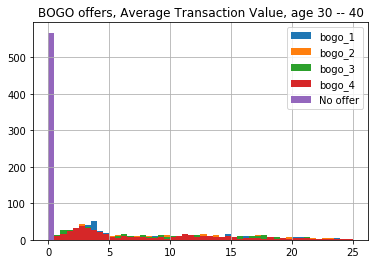

Average Transaction Value, age 40 - 50, bogo_1: 12.192168139027132
Average Transaction Value, age 40 - 50, bogo_2: 11.708607473254968
Average Transaction Value, age 40 - 50, bogo_3: 11.697031746915693
Average Transaction Value, age 40 - 50, bogo_4: 11.190896150156666
Average Transaction Value, age = 40 - 50, no offer: 8.26068922688789


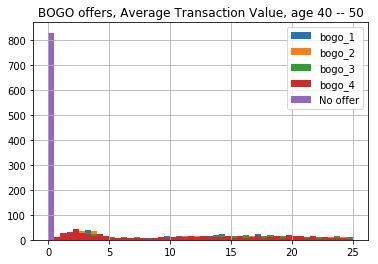

Average Transaction Value, age 50 - 60, bogo_1: 14.873940160800721
Average Transaction Value, age 50 - 60, bogo_2: 15.242164741468665
Average Transaction Value, age 50 - 60, bogo_3: 14.12189810024079
Average Transaction Value, age 50 - 60, bogo_4: 14.272457016917633
Average Transaction Value, age = 50 - 60, no offer: 9.315401209655644


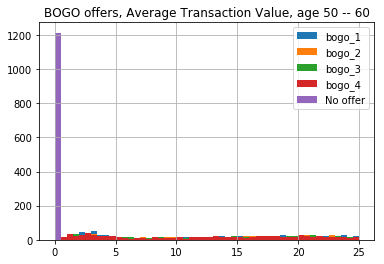

Average Transaction Value, age 60 - 70, bogo_1: 14.950388961026299
Average Transaction Value, age 60 - 70, bogo_2: 14.124418991133568
Average Transaction Value, age 60 - 70, bogo_3: 14.346309274864758
Average Transaction Value, age 60 - 70, bogo_4: 12.92658483245902
Average Transaction Value, age = 60 - 70, no offer: 9.483117801888694


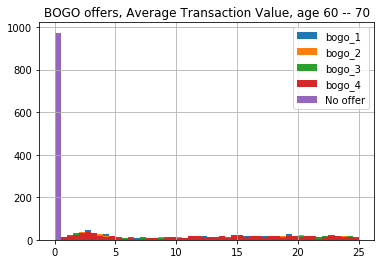

Average Transaction Value, age 70 - 80, bogo_1: 14.845503728147674
Average Transaction Value, age 70 - 80, bogo_2: 13.812027627951176
Average Transaction Value, age 70 - 80, bogo_3: 13.874519646100481
Average Transaction Value, age 70 - 80, bogo_4: 15.615206238069094
Average Transaction Value, age = 70 - 80, no offer: 10.549266339698757


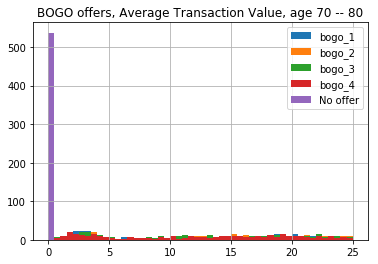

Average Transaction Value, age 80 - 90, bogo_1: 15.896249111713024
Average Transaction Value, age 80 - 90, bogo_2: 12.64353140589569
Average Transaction Value, age 80 - 90, bogo_3: 12.923763966599134
Average Transaction Value, age 80 - 90, bogo_4: 13.339358475370455
Average Transaction Value, age = 80 - 90, no offer: 11.38532193958665


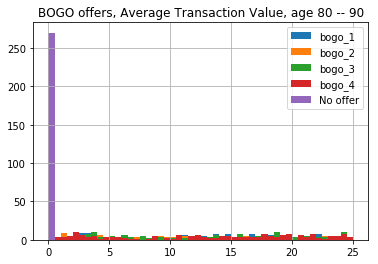

Average Transaction Value, age 90 - 100, bogo_1: 13.130171407957118
Average Transaction Value, age 90 - 100, bogo_2: 19.71043353174604
Average Transaction Value, age 90 - 100, bogo_3: 10.664773527842021
Average Transaction Value, age 90 - 100, bogo_4: 13.63832759202972
Average Transaction Value, age = 90 - 100, no offer: 9.368937786596119


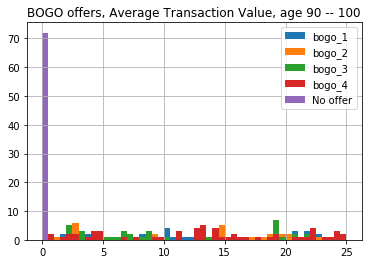

Average Transaction Value, age 100 - 110, bogo_1: nan
Average Transaction Value, age 100 - 110, bogo_2: nan
Average Transaction Value, age 100 - 110, bogo_3: 14.629999999999999
Average Transaction Value, age 100 - 110, bogo_4: 29.47
Average Transaction Value, age = 100 - 110, no offer: 9.3


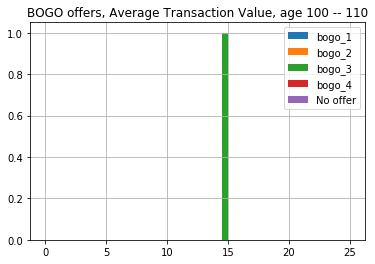

In [124]:
#age - transaction value, bogo
for i in range(2, 12):
    age_lower = (i-1) * 10
    age_upper = i * 10
    
    no_offer_avg = df[((df['bogo_1'] != 0) | (df['bogo_2'] != 0) | (df['bogo_3'] != 0) | (df['bogo_4'] != 0))  & ((df['age'] > age_lower) & (df['age'] <= age_upper))]['no_offer_avg_val'].mean()
    age_string = 'age_' + str(age_lower) + '_' + str(age_upper)
    set_finding('bogo_no_offer', age_string, 'avg_val', no_offer_avg)
    set_finding('bogo_no_offer', age_string, 'delta_val', 1) 
    
    for offer_name in ('bogo_1', 'bogo_2', 'bogo_3', 'bogo_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['age'] > age_lower) & (df['age'] <= age_upper))][data_col].mean()
        print('Average Transaction Value, age ' + str(age_lower) + ' - ' + str(age_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, age_string, 'avg_val', offer_avg )
        set_finding(offer_name, age_string, 'delta_val', (offer_avg / no_offer_avg))       
        
    df[(df['bogo_1'] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)]['no_offer_rate'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('BOGO offers, Average Transaction Value, age ' + str(age_lower) + ' -- ' + str(age_upper))
            
    print('Average Transaction Value, ' + 'age = ' + str(age_lower) + " - " + str(age_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    

Transaction Rate, age 10 - 20, discount_1: 0.00787121212121212
Transaction Rate, age 10 - 20, discount_2: 0.007698051008597873
Transaction Rate, age 10 - 20, discount_3: 0.00697083766008999
Transaction Rate, age 10 - 20, discount_4: 0.007221771284271274
Transaction Rate, age = 10 - 20, no offer: 0.0062186098163021135


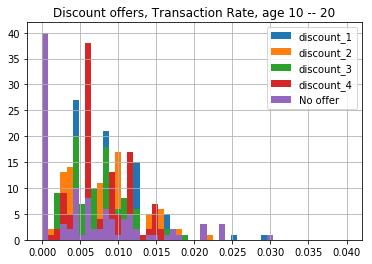

Transaction Rate, age 20 - 30, discount_1: 0.007930180903446826
Transaction Rate, age 20 - 30, discount_2: 0.007130041637095884
Transaction Rate, age 20 - 30, discount_3: 0.007008242238195097
Transaction Rate, age 20 - 30, discount_4: 0.007518943417604987
Transaction Rate, age = 20 - 30, no offer: 0.006151201462917088


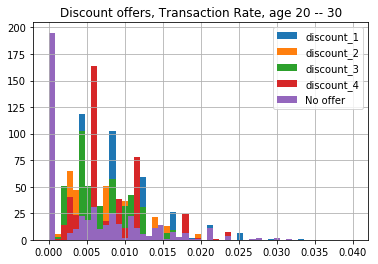

Transaction Rate, age 30 - 40, discount_1: 0.007153672392198989
Transaction Rate, age 30 - 40, discount_2: 0.006995918457169632
Transaction Rate, age 30 - 40, discount_3: 0.006804956801842217
Transaction Rate, age 30 - 40, discount_4: 0.006952422769810458
Transaction Rate, age = 30 - 40, no offer: 0.006375602991309491


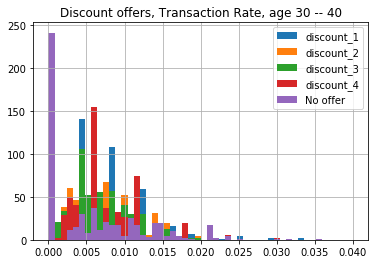

Transaction Rate, age 40 - 50, discount_1: 0.005830590213456372
Transaction Rate, age 40 - 50, discount_2: 0.005484818911582044
Transaction Rate, age 40 - 50, discount_3: 0.004978089093506741
Transaction Rate, age 40 - 50, discount_4: 0.005380512310064238
Transaction Rate, age = 40 - 50, no offer: 0.005384960861155013


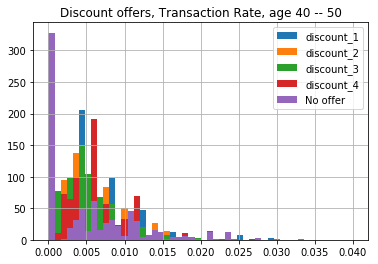

Transaction Rate, age 50 - 60, discount_1: 0.005098883357213766
Transaction Rate, age 50 - 60, discount_2: 0.005068406292935064
Transaction Rate, age 50 - 60, discount_3: 0.004971217679944138
Transaction Rate, age 50 - 60, discount_4: 0.004991117974967835
Transaction Rate, age = 50 - 60, no offer: 0.0053786639533328785


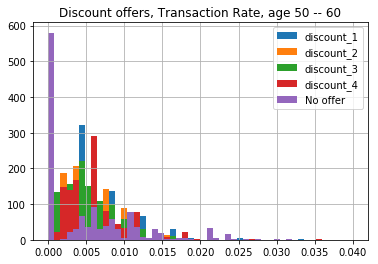

Transaction Rate, age 60 - 70, discount_1: 0.0052359492183970645
Transaction Rate, age 60 - 70, discount_2: 0.0051581771981706725
Transaction Rate, age 60 - 70, discount_3: 0.005091479509506908
Transaction Rate, age 60 - 70, discount_4: 0.004934740583533574
Transaction Rate, age = 60 - 70, no offer: 0.005163941666126514


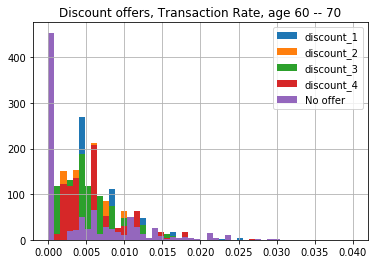

Transaction Rate, age 70 - 80, discount_1: 0.00532239451423893
Transaction Rate, age 70 - 80, discount_2: 0.005482932210416677
Transaction Rate, age 70 - 80, discount_3: 0.004766988550470714
Transaction Rate, age 70 - 80, discount_4: 0.005054585340050309
Transaction Rate, age = 70 - 80, no offer: 0.0050821381780955825


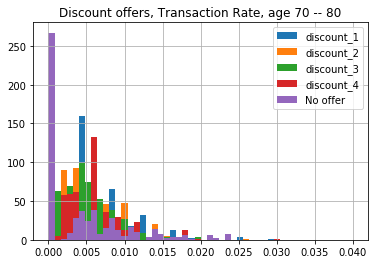

Transaction Rate, age 80 - 90, discount_1: 0.0049393342468882
Transaction Rate, age 80 - 90, discount_2: 0.005418498199026237
Transaction Rate, age 80 - 90, discount_3: 0.004968181818181813
Transaction Rate, age 80 - 90, discount_4: 0.005105051788725247
Transaction Rate, age = 80 - 90, no offer: 0.005085627888575353


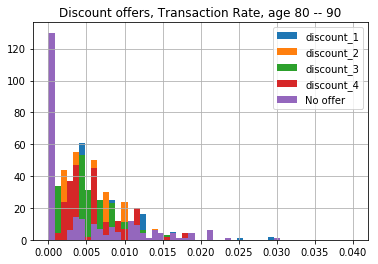

Transaction Rate, age 90 - 100, discount_1: 0.0046351969057665246
Transaction Rate, age 90 - 100, discount_2: 0.005063439849624058
Transaction Rate, age 90 - 100, discount_3: 0.005083689458689459
Transaction Rate, age 90 - 100, discount_4: 0.004728432700993674
Transaction Rate, age = 90 - 100, no offer: 0.00590552251296241


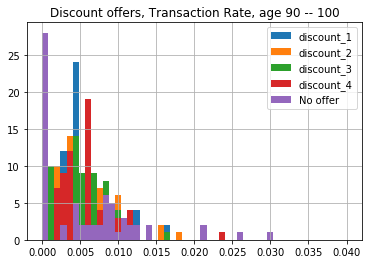

Transaction Rate, age 100 - 110, discount_1: 0.0034722222222222225
Transaction Rate, age 100 - 110, discount_2: 0.00992063492063492
Transaction Rate, age 100 - 110, discount_3: 0.005208333333333333
Transaction Rate, age 100 - 110, discount_4: 0.004629629629629629
Transaction Rate, age = 100 - 110, no offer: 0.00807514245014245


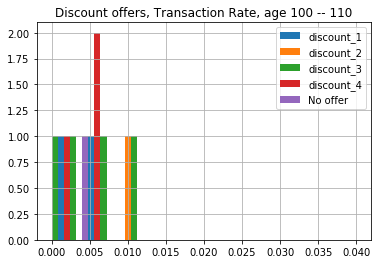

In [125]:
#age - transaction rate, discount

for i in range(2, 12):
    age_lower = (i-1) * 10
    age_upper = i * 10

    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0) | (df['discount_3'] != 0) | (df['discount_4'] != 0))  & ((df['age'] > age_lower) & (df['age'] <= age_upper))]['no_offer_rate'].mean()
    age_string = 'age_' + str(age_lower) + '_' + str(age_upper)
    set_finding('discount_no_offer', age_string, 'trans_rate', no_offer_avg)
    set_finding('discount_no_offer', age_string, 'delta_trans', 1) 
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['age'] > age_lower) & (df['age'] <= age_upper))][data_col].mean()
        print('Transaction Rate, age ' + str(age_lower) + ' - ' + str(age_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, age_string, 'trans_rate', offer_avg )
        set_finding(offer_name, age_string, 'delta_trans', (offer_avg / no_offer_avg))       
        
    df[(df['discount_1'] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Discount offers, Transaction Rate, age ' + str(age_lower) + ' -- ' + str(age_upper))
            
    print('Transaction Rate, ' + 'age = ' + str(age_lower) + " - " + str(age_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    

Average Transaction Value, age 10 - 20, discount_1: 6.423182153957155
Average Transaction Value, age 10 - 20, discount_2: 10.234866612554114
Average Transaction Value, age 10 - 20, discount_3: 6.21792956418479
Average Transaction Value, age 10 - 20, discount_4: 6.10237533068783
Average Transaction Value, age = 10 - 20, no offer: 5.351997368421049


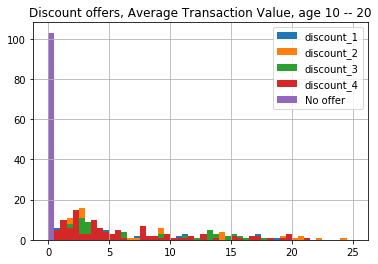

Average Transaction Value, age 20 - 30, discount_1: 7.231391521398749
Average Transaction Value, age 20 - 30, discount_2: 6.51836584310765
Average Transaction Value, age 20 - 30, discount_3: 7.063763931450712
Average Transaction Value, age 20 - 30, discount_4: 7.3265116377673625
Average Transaction Value, age = 20 - 30, no offer: 4.513640585241731


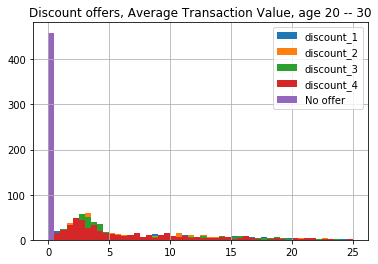

Average Transaction Value, age 30 - 40, discount_1: 9.906736603931046
Average Transaction Value, age 30 - 40, discount_2: 8.866644727413103
Average Transaction Value, age 30 - 40, discount_3: 10.161844768834973
Average Transaction Value, age 30 - 40, discount_4: 8.328317480125719
Average Transaction Value, age = 30 - 40, no offer: 6.42389569775849


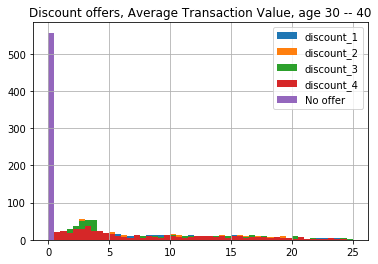

Average Transaction Value, age 40 - 50, discount_1: 11.372024267780276
Average Transaction Value, age 40 - 50, discount_2: 12.211181650532046
Average Transaction Value, age 40 - 50, discount_3: 12.537409451169074
Average Transaction Value, age 40 - 50, discount_4: 11.757507732532261
Average Transaction Value, age = 40 - 50, no offer: 8.52382436846689


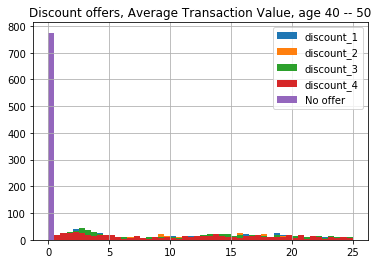

Average Transaction Value, age 50 - 60, discount_1: 14.719669558266533
Average Transaction Value, age 50 - 60, discount_2: 14.57603648381015
Average Transaction Value, age 50 - 60, discount_3: 16.472622108505725
Average Transaction Value, age 50 - 60, discount_4: 14.590939797865511
Average Transaction Value, age = 50 - 60, no offer: 8.636645564079524


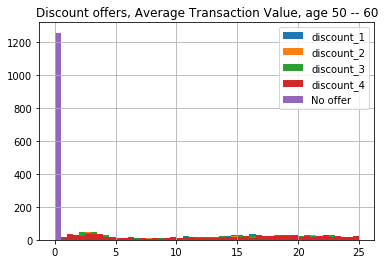

Average Transaction Value, age 60 - 70, discount_1: 17.058714526206266
Average Transaction Value, age 60 - 70, discount_2: 14.941256881008671
Average Transaction Value, age 60 - 70, discount_3: 15.305000026684487
Average Transaction Value, age 60 - 70, discount_4: 15.605605252711795
Average Transaction Value, age = 60 - 70, no offer: 8.562959504354861


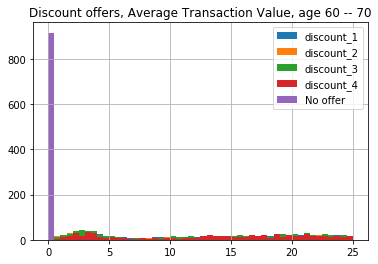

Average Transaction Value, age 70 - 80, discount_1: 15.817446245061758
Average Transaction Value, age 70 - 80, discount_2: 15.577591682100882
Average Transaction Value, age 70 - 80, discount_3: 16.48891288559023
Average Transaction Value, age 70 - 80, discount_4: 14.234731714378318
Average Transaction Value, age = 70 - 80, no offer: 9.177550375133976


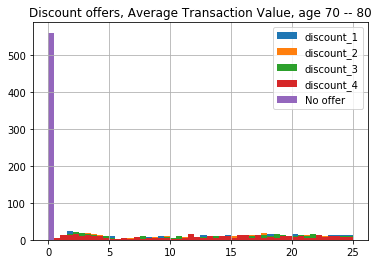

Average Transaction Value, age 80 - 90, discount_1: 15.719647530826478
Average Transaction Value, age 80 - 90, discount_2: 13.846841737513552
Average Transaction Value, age 80 - 90, discount_3: 18.65312789648853
Average Transaction Value, age 80 - 90, discount_4: 14.295238574917148
Average Transaction Value, age = 80 - 90, no offer: 10.725721476510067


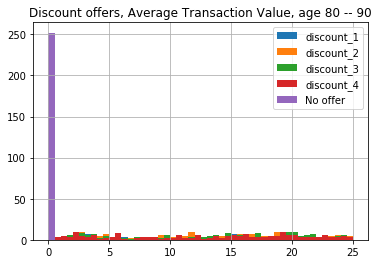

Average Transaction Value, age 90 - 100, discount_1: 23.26137110709262
Average Transaction Value, age 90 - 100, discount_2: 18.1308932748538
Average Transaction Value, age 90 - 100, discount_3: 16.09130188863843
Average Transaction Value, age 90 - 100, discount_4: 24.250653019744473
Average Transaction Value, age = 90 - 100, no offer: 9.41929841269841


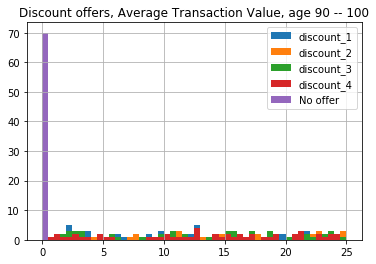

Average Transaction Value, age 100 - 110, discount_1: 23.7125
Average Transaction Value, age 100 - 110, discount_2: 27.609999999999996
Average Transaction Value, age 100 - 110, discount_3: 15.8944375
Average Transaction Value, age 100 - 110, discount_4: 16.817333333333334
Average Transaction Value, age = 100 - 110, no offer: 12.54


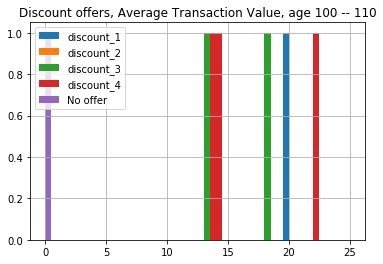

In [126]:
#age - transaction value, discount

for i in range(2, 12):
    age_lower = (i-1) * 10
    age_upper = i * 10

    no_offer_avg = df[((df['discount_1'] != 0) | (df['discount_2'] != 0))  & ((df['age'] > age_lower) & (df['age'] <= age_upper))]['no_offer_avg_val'].mean()
    age_string = 'age_' + str(age_lower) + '_' + str(age_upper)
    set_finding('discount_no_offer', age_string, 'avg_val', no_offer_avg)
    set_finding('discount_no_offer', age_string, 'delta_val', 1) 
    
    for offer_name in ('discount_1', 'discount_2', 'discount_3', 'discount_4'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['age'] > age_lower) & (df['age'] <= age_upper))][data_col].mean()
        print('Average Transaction Value, age ' + str(age_lower) + ' - ' + str(age_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, age_string, 'avg_val', offer_avg )
        set_finding(offer_name, age_string, 'delta_val', (offer_avg / no_offer_avg))      
        
    df[(df['discount_1'] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)]['no_offer_rate'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Discount offers, Average Transaction Value, age ' + str(age_lower) + ' -- ' + str(age_upper))
            
    print('Average Transaction Value, ' + 'age = ' + str(age_lower) + " - " + str(age_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()

Transaction Rate, age 10 - 20, info_1: 0.010099085365853659
Transaction Rate, age 10 - 20, info_2: 0.010917634051962397
Transaction Rate, age = 10 - 20, no offer: 0.006195657463541606


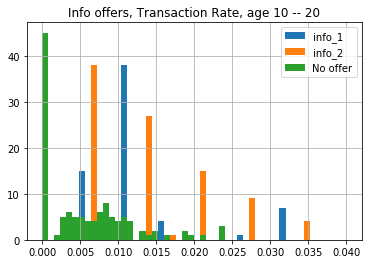

Transaction Rate, age 20 - 30, info_1: 0.010335372574955901
Transaction Rate, age 20 - 30, info_2: 0.010746690465565993
Transaction Rate, age = 20 - 30, no offer: 0.006060031466047535


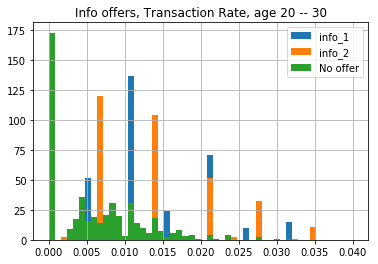

Transaction Rate, age 30 - 40, info_1: 0.0093051463711186
Transaction Rate, age 30 - 40, info_2: 0.009978278792491177
Transaction Rate, age = 30 - 40, no offer: 0.0063221539968483335


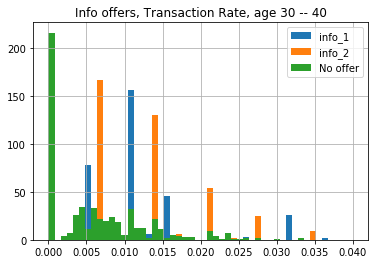

Transaction Rate, age 40 - 50, info_1: 0.007428436450167967
Transaction Rate, age 40 - 50, info_2: 0.008013979561358655
Transaction Rate, age = 40 - 50, no offer: 0.0054818661741346895


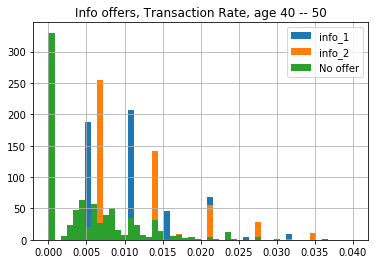

Transaction Rate, age 50 - 60, info_1: 0.007280711869618691
Transaction Rate, age 50 - 60, info_2: 0.007715984013241324
Transaction Rate, age = 50 - 60, no offer: 0.005308451537851675


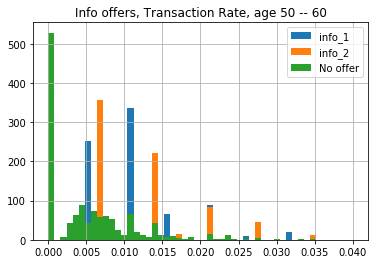

Transaction Rate, age 60 - 70, info_1: 0.007158564814814823
Transaction Rate, age 60 - 70, info_2: 0.007887453874538819
Transaction Rate, age = 60 - 70, no offer: 0.0053936146050835455


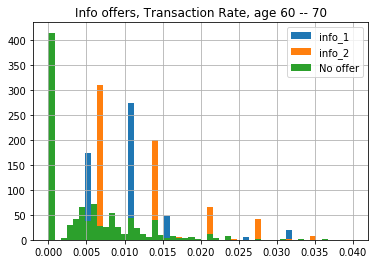

Transaction Rate, age 70 - 80, info_1: 0.007291666666666673
Transaction Rate, age 70 - 80, info_2: 0.007626488095238129
Transaction Rate, age = 70 - 80, no offer: 0.0048694696007638575


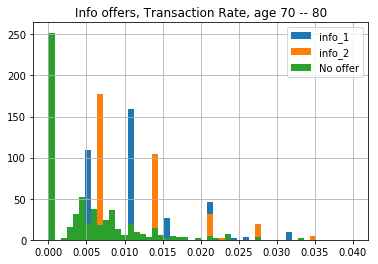

Transaction Rate, age 80 - 90, info_1: 0.008174535456958665
Transaction Rate, age 80 - 90, info_2: 0.008449456056716783
Transaction Rate, age = 80 - 90, no offer: 0.0053621198064999365


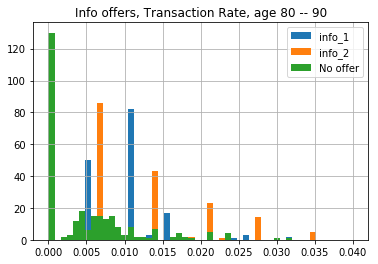

Transaction Rate, age 90 - 100, info_1: 0.006808483935742974
Transaction Rate, age 90 - 100, info_2: 0.007911392405063286
Transaction Rate, age = 90 - 100, no offer: 0.005318063768922296


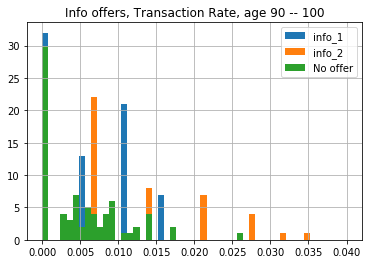

Transaction Rate, age 100 - 110, info_1: 0.013020833333333332
Transaction Rate, age 100 - 110, info_2: 0.003472222222222222
Transaction Rate, age = 100 - 110, no offer: 0.00807514245014245


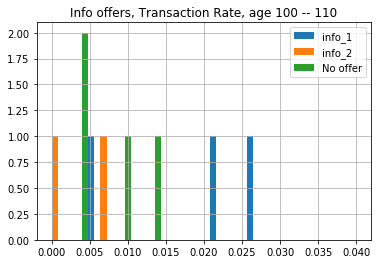

In [127]:
#age - transaction rate, info

for i in range(2, 12):
    age_lower = (i-1) * 10
    age_upper = i * 10

    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & ((df['age'] > age_lower) & (df['age'] <= age_upper))]['no_offer_rate'].mean()
    age_string = 'age_' + str(age_lower) + '_' + str(age_upper)
    set_finding('info_no_offer', age_string, 'trans_rate', no_offer_avg)
    set_finding('info_no_offer', age_string, 'delta_trans', 1) 
    
    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_rate'
        df[(df[offer_name] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)][data_col].hist(bins = 50, range=(0, 0.04), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['age'] > age_lower) & (df['age'] <= age_upper))][data_col].mean()
        print('Transaction Rate, age ' + str(age_lower) + ' - ' + str(age_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, age_string, 'trans_rate', offer_avg )
        set_finding(offer_name, age_string, 'delta_trans', (offer_avg / no_offer_avg))      
        
    df[(df['info_1'] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)]['no_offer_rate'].hist(bins = 50, range=(0, 0.04), label = 'No offer')
    plt.legend()
    plt.title('Info offers, Transaction Rate, age ' + str(age_lower) + ' -- ' + str(age_upper))
            
    print('Transaction Rate, ' + 'age = ' + str(age_lower) + " - " + str(age_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()
    

Average Transaction Value, age 10 - 20, info_1: 4.55743699186992
Average Transaction Value, age 10 - 20, info_2: 5.594742537313429
Average Transaction Value, age = 10 - 20, no offer: 4.787402190923314


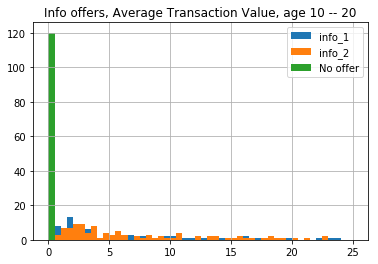

Average Transaction Value, age 20 - 30, info_1: 7.11325277935248
Average Transaction Value, age 20 - 30, info_2: 5.941729082998658
Average Transaction Value, age = 20 - 30, no offer: 4.808606147021548


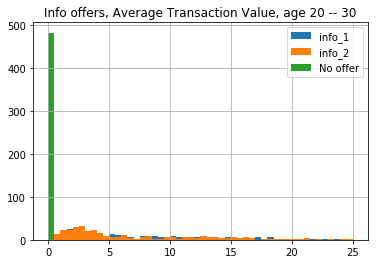

Average Transaction Value, age 30 - 40, info_1: 7.045945045695052
Average Transaction Value, age 30 - 40, info_2: 8.37098937321239
Average Transaction Value, age = 30 - 40, no offer: 6.658263315696649


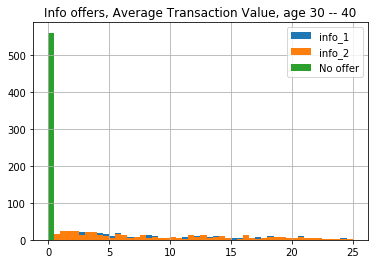

Average Transaction Value, age 40 - 50, info_1: 9.783754688138782
Average Transaction Value, age 40 - 50, info_2: 8.937181204739955
Average Transaction Value, age = 40 - 50, no offer: 8.970484275934158


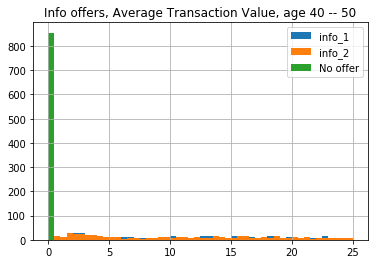

Average Transaction Value, age 50 - 60, info_1: 11.41836910911967
Average Transaction Value, age 50 - 60, info_2: 11.037127690117309
Average Transaction Value, age = 50 - 60, no offer: 9.944010090809815


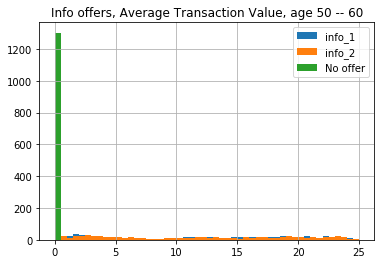

Average Transaction Value, age 60 - 70, info_1: 10.678574818594095
Average Transaction Value, age 60 - 70, info_2: 10.226437265711938
Average Transaction Value, age = 60 - 70, no offer: 9.872066888738962


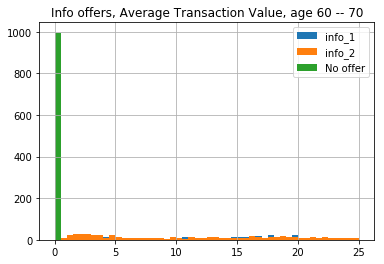

Average Transaction Value, age 70 - 80, info_1: 10.764780019047612
Average Transaction Value, age 70 - 80, info_2: 10.134692254174393
Average Transaction Value, age = 70 - 80, no offer: 11.516797043010738


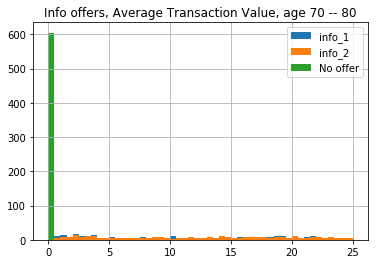

Average Transaction Value, age 80 - 90, info_1: 10.94088432471965
Average Transaction Value, age 80 - 90, info_2: 9.678802805280522
Average Transaction Value, age = 80 - 90, no offer: 10.448830561330563


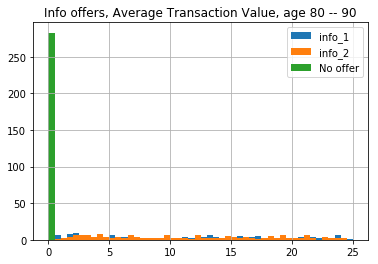

Average Transaction Value, age 90 - 100, info_1: 9.413202811244979
Average Transaction Value, age 90 - 100, info_2: 8.398073136427568
Average Transaction Value, age = 90 - 100, no offer: 9.05160336356765


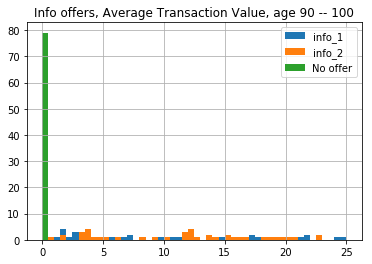

Average Transaction Value, age 100 - 110, info_1: 13.373000000000001
Average Transaction Value, age 100 - 110, info_2: 21.935
Average Transaction Value, age = 100 - 110, no offer: 11.5425


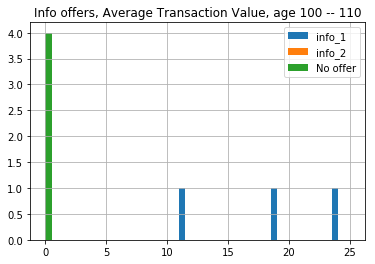

In [128]:
#age - transaction value, info

for i in range(2, 12):
    age_lower = (i-1) * 10
    age_upper = i * 10

    no_offer_avg = df[((df['info_1'] != 0) | (df['info_2'] != 0))  & ((df['age'] > age_lower) & (df['age'] <= age_upper))]['no_offer_avg_val'].mean()
    age_string = 'age_' + str(age_lower) + '_' + str(age_upper)
    set_finding('info_no_offer', age_string, 'avg_val', no_offer_avg)
    set_finding('info_no_offer', age_string, 'delta_val', 1) 
    
    for offer_name in ('info_1', 'info_2'):
        data_col = offer_name + '_avg_val'
        df[(df[offer_name] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)][data_col].hist(bins = 50, range=(0, 25), label = offer_name)
        offer_avg = df[(df[offer_name] != 0) & ( (df['age'] > age_lower) & (df['age'] <= age_upper))][data_col].mean()
        print('Average Transaction Value, age ' + str(age_lower) + ' - ' + str(age_upper) + ', ' + offer_name + ': ' + str(offer_avg)) 
        set_finding(offer_name, age_string, 'avg_val', offer_avg )
        set_finding(offer_name, age_string, 'delta_val', (offer_avg / no_offer_avg))       
        
    df[(df['info_1'] != 0) & (df['age'] <= age_upper) & (df['age'] > age_lower)]['no_offer_rate'].hist(bins = 50, range=(0, 25), label = 'No offer')
    plt.legend()
    plt.title('Info offers, Average Transaction Value, age ' + str(age_lower) + ' -- ' + str(age_upper))
            
    print('Average Transaction Value, ' + 'age = ' + str(age_lower) + " - " + str(age_upper) + ', no offer: ' + str(no_offer_avg))
    plt.show()

## Analyzing findings




In [130]:
df_findings['difficulty'] = np.NaN
df_findings['reward'] = np.NaN
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [131]:
#    df_findings.loc[(df_findings['Offer'] == offer) & (df_findings['Demographic'] == demographic), col_name] = val
df_findings.loc[df_findings['Offer'] == 'discount_1', 'difficulty'] = 20 #{'0b1e1539f2cc45b7b9fa7c272da2e1d7':
df_findings.loc[df_findings['Offer'] =='discount_2', 'difficulty'] = 7 # '2298d6c36e964ae4a3e7e9706d1fb8c2': 
df_findings.loc[df_findings['Offer'] =='discount_4', 'difficulty'] = 10 #  '2906b810c7d4411798c6938adc9daaa5': 
df_findings.loc[df_findings['Offer'] =='info_1', 'difficulty'] = 0    #  '3f207df678b143eea3cee63160fa8bed': 
df_findings.loc[df_findings['Offer'] =='bogo_2', 'difficulty'] = 10    #  '4d5c57ea9a6940dd891ad53e9dbe8da0': 
df_findings.loc[df_findings['Offer'] =='info_2' , 'difficulty'] = 0   #  '5a8bc65990b245e5a138643cd4eb9837': 
df_findings.loc[df_findings['Offer'] =='bogo_3', 'difficulty'] = 5    #  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 
df_findings.loc[df_findings['Offer'] =='bogo_1', 'difficulty'] = 10    #  'ae264e3637204a6fb9bb56bc8210ddfd': 
df_findings.loc[df_findings['Offer'] =='bogo_4', 'difficulty'] = 5    #  'f19421c1d4aa40978ebb69ca19b0e20d': 
df_findings.loc[df_findings['Offer'] =='discount_3', 'difficulty'] = 10 #  'fafdcd668e3743c1bb461111dcafc2a4': 
                
df_findings.loc[df_findings['Offer'] == 'discount_1', 'reward'] =  5 #{'0b1e1539f2cc45b7b9fa7c272da2e1d7':
df_findings.loc[df_findings['Offer'] =='discount_2', 'reward'] = 3 # '2298d6c36e964ae4a3e7e9706d1fb8c2': 
df_findings.loc[df_findings['Offer'] =='discount_4', 'reward'] = 2 #  '2906b810c7d4411798c6938adc9daaa5': 
df_findings.loc[df_findings['Offer'] =='info_1', 'reward'] = 0    #  '3f207df678b143eea3cee63160fa8bed': 
df_findings.loc[df_findings['Offer'] =='bogo_2', 'reward'] = 10    #  '4d5c57ea9a6940dd891ad53e9dbe8da0': 
df_findings.loc[df_findings['Offer'] =='info_2' , 'reward'] = 0   #  '5a8bc65990b245e5a138643cd4eb9837': 
df_findings.loc[df_findings['Offer'] =='bogo_3', 'reward'] = 5    #  '9b98b8c7a33c4b65b9aebfe6a799e6d9': 
df_findings.loc[df_findings['Offer'] =='bogo_1', 'reward'] = 10    #  'ae264e3637204a6fb9bb56bc8210ddfd': 
df_findings.loc[df_findings['Offer'] =='bogo_4', 'reward'] =  5   #  'f19421c1d4aa40978ebb69ca19b0e20d': 
df_findings.loc[df_findings['Offer'] =='discount_3', 'reward'] = 2 #  'fafdcd668e3743c1bb461111dcafc2a4': 

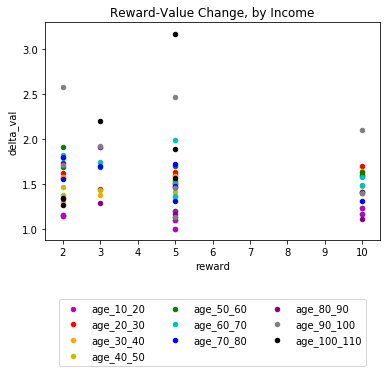

In [132]:
age_demographics = ['age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 'age_50_60', 'age_60_70', 'age_70_80',
                   'age_80_90', 'age_90_100', 'age_100_110']
colors = ['m', 'r', 'orange', 'y', 'g', 'c', 'b','purple','gray', 'k']


ax = df_findings[(df_findings['Demographic'] == 'age_10_20') & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_val')

for index, age in enumerate(age_demographics):
    df_findings[(df_findings['Demographic'] == age) & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_val', ax = ax, label = age, 
                                                                                                 color = colors[index], title = 'Reward-Value Change, by Income')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

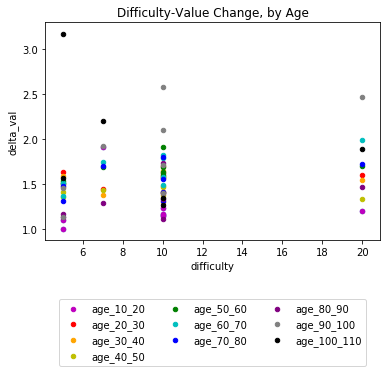

In [133]:
age_demographics = ['age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 'age_50_60', 'age_60_70', 'age_70_80',
                   'age_80_90', 'age_90_100', 'age_100_110']



ax = df_findings[(df_findings['Demographic'] == 'age_10_20') & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_val')

for index, age in enumerate(age_demographics):
    df_findings[(df_findings['Demographic'] == age) & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_val', ax = ax, label = age, 
                                                                                                     color = colors[index], title = 'Difficulty-Value Change, by Age')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

Conclusion: No obvious connection between age and difficulty or reward

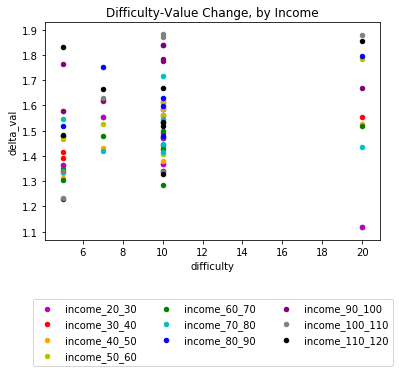

In [134]:
inc_demographics = ['income_20_30', 'income_30_40', 'income_40_50','income_50_60','income_60_70','income_70_80',
                    'income_80_90', 'income_90_100', 'income_100_110', 'income_110_120']

ax = df_findings[(df_findings['Demographic'] == 'income_20_30') & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_val')

for index, inc in enumerate(inc_demographics):
    df_findings[(df_findings['Demographic'] == inc) & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_val', ax = ax, label = inc, 
                                                                                                     color = colors[index], title = 'Difficulty-Value Change, by Income')
                                                                                                     

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

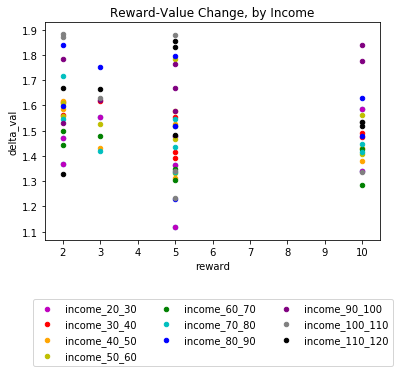

In [135]:
inc_demographics = ['income_20_30', 'income_30_40', 'income_40_50','income_50_60','income_60_70','income_70_80',
                    'income_80_90', 'income_90_100', 'income_100_110', 'income_110_120']

ax = df_findings[(df_findings['Demographic'] == 'income_20_30') & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_val')

for index, inc in enumerate(inc_demographics):
    df_findings[(df_findings['Demographic'] == inc) & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_val', ax = ax, label = inc, 
                                                                                        color = colors[index], title = 'Reward-Value Change, by Income')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

### Transaction Volume change

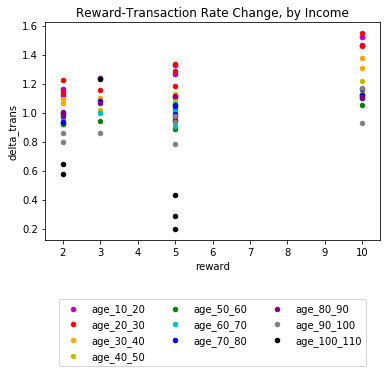

In [136]:
ax = df_findings[(df_findings['Demographic'] == 'age_10_20') & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_trans')

for index, age in enumerate(age_demographics):
    df_findings[(df_findings['Demographic'] == age) & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_trans', ax = ax, label = age, 
                                                                                                 color = colors[index], title = 'Reward-Transaction Rate Change, by Income')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

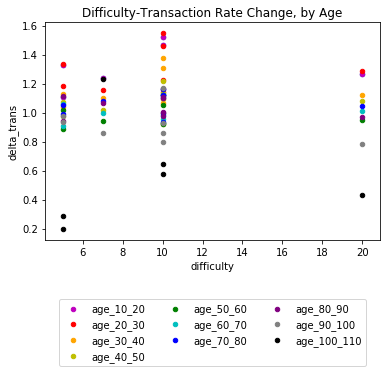

In [137]:
ax = df_findings[(df_findings['Demographic'] == 'age_10_20') & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_trans')

for index, age in enumerate(age_demographics):
    df_findings[(df_findings['Demographic'] == age) & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_trans', ax = ax, label = age, 
                                                                                                     color = colors[index], title = 'Difficulty-Transaction Rate Change, by Age')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

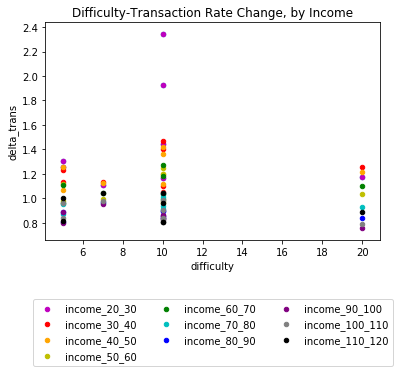

In [138]:
ax = df_findings[(df_findings['Demographic'] == 'income_20_30') & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_trans')

for index, inc in enumerate(inc_demographics):
    df_findings[(df_findings['Demographic'] == inc) & (df_findings['difficulty'] != 0)].plot.scatter(x = 'difficulty', y = 'delta_trans', ax = ax, label = inc, 
                                                                                                     color = colors[index], title = 'Difficulty-Transaction Rate Change, by Income')
                                                                                                     

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

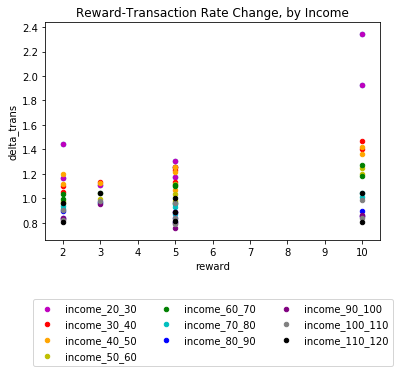

In [139]:
ax = df_findings[(df_findings['Demographic'] == 'income_20_30') & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_trans')

for index, inc in enumerate(inc_demographics):
    df_findings[(df_findings['Demographic'] == inc) & (df_findings['reward'] != 0)].plot.scatter(x = 'reward', y = 'delta_trans', ax = ax, label = inc, 
                                                                                        color = colors[index], title = 'Reward-Transaction Rate Change, by Income')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)
    
plt.show()

Younger and lower-inocme customers increased transaction rate, but independently of reward and difficuly.  There was no noticeable transaction value trend correltated to either income or age.

## Regression Learning

In [141]:
#df_findings
export_csv = df_findings.to_csv (r'findings2.csv', index = None, header=True)

In [142]:
df.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income', 'date_parsed',
       'member_for', 'discount_1', 'discount_2', 'discount_3', 'discount_4',
       'bogo_1', 'bogo_2', 'bogo_3', 'bogo_4', 'info_1', 'info_2',
       'bogo_1_transactions', 'bogo_2_transactions', 'bogo_3_transactions',
       'bogo_4_transactions', 'discount_1_transactions',
       'discount_2_transactions', 'discount_3_transactions',
       'discount_4_transactions', 'info_1_transactions', 'info_2_transactions',
       'no_offer_transactions', 'no_offer_interval', 'bogo_1_rate',
       'bogo_1_avg_val', 'bogo_2_rate', 'bogo_2_avg_val', 'bogo_3_rate',
       'bogo_3_avg_val', 'bogo_4_rate', 'bogo_4_avg_val', 'info_1_rate',
       'info_1_avg_val', 'info_2_rate', 'info_2_avg_val', 'discount_1_rate',
       'discount_1_avg_val', 'discount_2_rate', 'discount_2_avg_val',
       'discount_3_rate', 'discount_3_avg_val', 'discount_4_rate',
       'discount_4_avg_val', 'no_offer_rate', 'no_offer_avg_val'],
      dtype=

In [143]:
#X and y for the BOGO offers
'''
Given:
 -age
 -gender
 -number of months a member for
 -income
 -user's baseline transaction rate
 -user's baseline transaction average value
 -BOGO difficulty
 -BOGO reward
 
Predict using a linear model:
 -New transaction rate
 -New transaction average value
'''

X_bogo_1 = df[df['bogo_1'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_bogo_1['difficulty'] = 10
X_bogo_1['reward'] = 10
y_bogo_1 = df[df['bogo_1'] != 0][['bogo_1_rate', 'bogo_1_avg_val']]
y_bogo_1.columns = ['rate', 'avg_val']

X_bogo_2 = df[df['bogo_2'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_bogo_2['difficulty'] = 10
X_bogo_2['reward'] = 10
y_bogo_2 = df[df['bogo_2'] != 0][['bogo_2_rate', 'bogo_2_avg_val']]
y_bogo_2.columns = ['rate', 'avg_val']

X_bogo_3 = df[df['bogo_3'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_bogo_3['difficulty'] = 5
X_bogo_3['reward'] = 5
y_bogo_3 = df[df['bogo_3'] != 0][['bogo_3_rate', 'bogo_3_avg_val']]
y_bogo_3.columns = ['rate', 'avg_val']

X_bogo_4 = df[df['bogo_4'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_bogo_4['difficulty'] = 5
X_bogo_4['reward'] = 5
y_bogo_4 = df[df['bogo_4'] != 0][['bogo_4_rate', 'bogo_4_avg_val']]
y_bogo_4.columns = ['rate', 'avg_val']

X_bogo_cat = pd.concat([X_bogo_1, X_bogo_2, X_bogo_3, X_bogo_4])

y_bogo = pd.concat([y_bogo_1, y_bogo_2, y_bogo_3, y_bogo_4])

skewed = ['age', 'member_for', 'income', 'no_offer_rate', 'no_offer_avg_val', 'difficulty', 'reward']
X_bogo_deskew = X_bogo_cat.copy()
X_bogo_deskew[skewed] = X_bogo_cat[skewed].apply(lambda x: np.log(x + 1))

X_bogo_imp = pd.get_dummies(X_bogo_deskew)

imp = Imputer(strategy='mean')
X_bogo_scal = imp.fit_transform(X_bogo_imp)

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
X_bogo = scaler.fit_transform(X_bogo_scal)



In [144]:
#X and y for the Discount offers
'''
Given:
 -age
 -gender
 -number of months a member for
 -income
 -user's baseline transaction rate
 -user's baseline transaction average value
 -Discount difficulty
 -Discount reward
 
Predict using a linear model:
 -New transaction rate
 -New transaction average value
'''

X_discount_1 = df[df['discount_1'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_discount_1['difficulty'] = 20
X_discount_1['reward'] = 5
y_discount_1 = df[df['discount_1'] != 0][['discount_1_rate', 'discount_1_avg_val']]
y_discount_1.columns = ['rate', 'avg_val']

X_discount_2 = df[df['discount_2'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_discount_2['difficulty'] = 7
X_discount_2['reward'] = 3
y_discount_2 = df[df['discount_2'] != 0][['discount_2_rate', 'discount_2_avg_val']]
y_discount_2.columns = ['rate', 'avg_val']

X_discount_3 = df[df['discount_3'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_discount_3['difficulty'] = 10
X_discount_3['reward'] = 2
y_discount_3 = df[df['discount_3'] != 0][['discount_3_rate', 'discount_3_avg_val']]
y_discount_3.columns = ['rate', 'avg_val']

X_discount_4 = df[df['discount_4'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
X_discount_4['difficulty'] = 10
X_discount_4['reward'] = 2
y_discount_4 = df[df['discount_4'] != 0][['discount_4_rate', 'discount_4_avg_val']]
y_discount_4.columns = ['rate', 'avg_val']


X_discount_cat = pd.concat([X_discount_1, X_discount_2, X_discount_3, X_discount_4])



y_discount = pd.concat([y_discount_1, y_discount_2, y_discount_3, y_discount_4])

X_discount_deskew = X_discount_cat.copy()
X_discount_deskew[skewed] = X_discount_cat[skewed].apply(lambda x: np.log(x + 1))

X_discount_imp = pd.get_dummies(X_discount_deskew)

X_discount = imp.fit_transform(X_discount_imp)



In [147]:
#X and y for the Info offers
'''
Given:
 -age
 -gender
 -number of months a member for
 -income
 -user's baseline transaction rate
 -user's baseline transaction average value
 
Predict using a linear model:
 -New transaction rate
 -New transaction average value
'''

X_info_1 = df[df['info_1'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
y_info_1 = df[df['info_1'] != 0][['info_1_rate', 'info_1_avg_val']]
y_info_1.columns = ['rate', 'avg_val']

X_info_2 = df[df['info_2'] != 0][['age', 'member_for', 'income', 'gender', 'no_offer_rate', 'no_offer_avg_val']]
y_info_2 = df[df['info_2'] != 0][['info_2_rate', 'info_2_avg_val']]
y_info_2.columns = ['rate', 'avg_val']

X_info_cat = pd.concat([X_info_1, X_info_2])

X_info_imp = pd.get_dummies(X_info_cat)
#X_info = imp.fit_transform(X_info_imp)
y_info = pd.concat([y_info_1, y_info_2])

skewed = ['age', 'member_for', 'income', 'no_offer_rate', 'no_offer_avg_val']

X_info_deskew = X_info_imp.copy()
X_info_deskew[skewed] = X_info_cat[skewed].apply(lambda x: np.log(x + 1))

X_info_imp = pd.get_dummies(X_info_deskew)

X_info = imp.fit_transform(X_info_imp)

In [150]:
#X_train, X_test, y_train, y_test = train_test_split(X_bogo, y_bogo['rate'], random_state=42)

#bogo_rate_model = LinearRegression()
#bogo_rate_model.fit(X_train, y_train)

#bogo_rate_model.score(X_test, y_test)

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X_bogo, y_bogo['rate'], random_state=42)

#bogo_rate_model=AdaBoostRegressor()
bogo_rate_model = LinearRegression()
bogo_rate_model.fit(X_train, y_train)
y_pred = bogo_rate_model.predict(X_test)

print('R^2 score: ' + str(bogo_rate_model.score(X_test, y_test)))
print('MSE: ' + str(mean_squared_error(y_test, y_pred)))



R^2 score: 0.232912984953061
MSE: 2.267977673858029e-05


In [155]:


X_train, X_test, y_train, y_test = train_test_split(X_discount, y_discount['avg_val'], random_state=42)

#bogo_rate_model=AdaBoostRegressor()
discount_rate_model = LinearRegression()
discount_rate_model.fit(X_train, y_train)
y_pred = discount_rate_model.predict(X_test)

print('R^2 score: ' + str(discount_rate_model.score(X_test, y_test)))
print('MSE: ' + str(mean_squared_error(y_test, y_pred)))

R^2 score: 0.0749508327553936
MSE: 629.2410697984262


In [153]:

X_train, X_test, y_train, y_test = train_test_split(X_info, y_info['rate'], random_state=42)

#bogo_rate_model=AdaBoostRegressor()
info_rate_model = LinearRegression()
info_rate_model.fit(X_train, y_train)
y_pred = info_rate_model.predict(X_test)

print('R^2 score: ' + str(info_rate_model.score(X_test, y_test)))
print('MSE: ' + str(mean_squared_error(y_test, y_pred)))

R^2 score: 0.11630661393103037
MSE: 6.6885574823446e-05


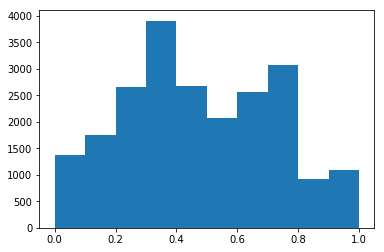

In [161]:
## Illustration of scaled and normalized data
plt.hist(X_bogo[:,1])
plt.show()